<a id=TOC></a>
__Week 6 Live Session Demo: Linear Regression & Gradient Descent__  
`MIDS w261, Machine Learning at Scale `

<a id=intro></a>
# Introduction
[Return to Contents](#TOC) | [Skip to Appendix](#Appendix)

In today's demo, we'll use Linear Regression as a simple example in order to explore key topics related to distributed learning of parametric models. Broadly speaking, the supervised learning of a parametric model can be split into to two components:
1. **Prediction Task**: Given an input vector, return an output value.
2. **Optimization Task (a.k.a. Learning)**: Given a strategy for making a prediction, return the specific parameters which guarantee the optimal prediction.

> __DISCUSSION QUESTION:__ _In the case of Linear Regression, which of the two tasks above are we most likely to want to parallelize? Why?_


OK, Let's start with a quick review of some notation you will have seen in w207. 

## Notation Review

Linear Regression tackles the __prediction task__ by assuming that we can compute our output variable, $y$, using a linear combination of our input variables. That is we assume there exist a set of **weights**, $\mathbf{w}$, and a **bias** term, $\mathbf{b}$, such that for any input $\mathbf{x}_j \in \mathbb{R}^m$:

\begin{equation}\tag{1.1}
y_j = \displaystyle\sum_{i=1}^{m}{w_i\cdot x_{ji} + b}
\end{equation}

In vector notation, this can be written:

\begin{equation}
y_j = \displaystyle{\mathbf{w}^T\mathbf{x}_{j} + b}
\end{equation}

Of course, this perfect linear relationship never holds over a whole dataset **$X$**, so Linear Regression attempts to fit (i.e. **learn**) the best line (in 1 dimension) or hyperplane (in 2 or more dimensions) to the data.  In the case of **ordinary least squares (OLS)** linear regression, best fit is defined as minimizing the Euclidean distances of each point in the dataset to the line or hyperplane.  These distances are often referred to as **residuals**. 

<img src='residual.png' width="400" height="200">

The calculation of the average residual (a.k.a.**mean squared error, MSE**) over our test or training set allows us to measure how good a fit we've achieved. We call this function the **loss** or **objective** function because our goal in the **optimization task** is to find the parameters which minimize it.

\begin{equation}\tag{1.2}
f(\mathbf{w}, b) = \frac{1}{n}\sum_{j=1}^{n}\left[ (\mathbf{w}^T\mathbf{x}_j + b) - y_i\right]^2,\\
n = \left|X_{\text{train}}\right|
\end{equation}

For convenience, we sometimes choose to think of the bias $b$ as weight $w_{m+1}$. To operationalize this, we'll _augment_ our input vectors by setting $x_{m+1}=1$. This gives us a simpler way to write the loss function:
$$
\mathbf{x}' :=
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
$$

\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}

Machine Learning packages like `sklearn` and `tensorflow` take this one step further by representing the entire training set in a single matrix were each row is an input vector and each column represents a feature:
$$
\text{X}' =
\begin{bmatrix}
\mathbf{x'}_1^{\text{T}}\\
\vdots\\
\mathbf{x'}_n^{\text{T}}
\end{bmatrix},\quad
\mathbf{y} = 
\begin{bmatrix}
y_1\\
\vdots\\
y_n
\end{bmatrix}
$$

\begin{equation}\tag{1.4}
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
\end{equation}

As you see here, it is customary to write loss as a function of the parameters $\theta$ (or equivalently $\mathbf{w}$ and $b$). However it is important to note that the MSE loss depends on both the parameters/weights  _and_ the data $X$, we'll talk more about that later.

> __DISCUSSION QUESTIONS:__ 
* _In equation 1.1 what do $x_{ji}$, $w_i$, and $\mathbf{w}$ each represent?_  
* _In the asynch's version of the loss function $\alpha$ and $\beta$ appear as parameters... what do they represent? How are they captured in equations 1.2 and 1.3 respectively?_ 
* _If we were computing loss over a really large data set what might be the arguments in favor / against using the augmented version of the loss function calculation?_

## Notebook Set Up

In [2]:
# install seaborn if you haven't already
!pip install seaborn

In [25]:
# general imports
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

__IMPORTANT!__ Before we begin, please run the cells in [Appendix B](#AppendixB) to generate the supporting files & helper code that we'll use in our demos. When you're done, return here to get started.

In [10]:
# import helper modules
import helperFunc
import linRegFunc

# OPTIONAL - uncomment to print helper file docstrings
print helperFunc.__doc__
# print linRegFunc.__doc__


This file contains helper functions for generating, transforming
and plotting 2 dimensional data to use in testing & for ML demos.

Avaliable functions include:
    augment(X)
    plot2DModels(data, models=[], names = [], title=None)
    plotErrorSurface(data, weight_grid, loss, title=None)




<a id=small_ex></a>
# A Small Example
[Return to Contents](#TOC) | [Jump to Demo 1](#demo1) | [Skip to Appendix](#Appendix)

We'll start with a small example of 5 2-D points:

In [6]:
%%writefile fivePoints.csv
1,2
3,4
5,5
4,3
2,3

Overwriting fivePoints.csv


In [7]:
# load data from file
points = np.genfromtxt("fivePoints.csv", delimiter=',')

Here's what they look like next to a the simplest possible linear model:  $ y = x$

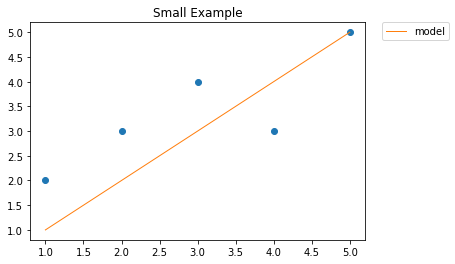

In [11]:
# easy plotting with a helper function
helperFunc.plot2DModels(points, [[0,1]],['model'], title = 'Small Example')

Looks reasonable, but its hard to gauge exactly how good a fit we have just by looking.

> __A TASK FOR YOU:__ Fill in the calculations below to compute the "Training Loss" for our data. These are easy and intuitive calculations that you will know from long-ago math classes... but instead of relying on your visual intuition, challenge yourself to think through these numbers in the context of our matrix equation for loss. Here it is again for your reference:
\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}


The parameter vector $\theta$ for our initial line $y=x$ is: 
$ \begin{bmatrix} ? \ \quad ? \ \end{bmatrix}$
         
The (augmented) data points $x_j$ are:
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$

Our loss calculations will be:

|$j$  | $y_j$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_i$ | $\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2$ |
|:---:|:-----:|:----------------:|:------------------------:|
|     | true y   |   predicted y   |  squared residual       |
| 1   |       |                  |             |
| 2   |       |                  |    |
| 3   |       |                  |    |
| 4   |       |                  |    |
| 5   |       |                  |    |

 The training loss $f(\boldsymbol{\theta})$ for this data and these weights is: _______
 

In [12]:
# confirm your hand calculation by running this cell
X = helperFunc.augment(points)[:,:-1]
y = points[:,-1]
print "Loss:", linRegFunc.OLSLoss(X, y,[0,1])

Loss: 3.4


 > __DISCUSSION QUESTIONS:__ 
 * _What parts of this computation could be parallelized? What, if any, aggregation has to happen at the end?_ 
 * _What key-value format, partitioning, sorting would help? Could you use a combiner?_ 
 * _In addition to the data stream, what other information would your map or reduce tasks need access to?_ 

<a id=demo1></a>
## Demo: Random Parameter Search.
[Return to Contents](#TOC) | [Skip to Appendix](#Appendix)

Ok, so we know the model looks ok and we know its loss is $0.4$ but is that any good? A naive approach to "learning" a Linear Model might be to randomly generate a few more models and then pick the model with the lowest loss. Let's try it.

Best Random Model: [ 0.9223559  1.4658498], Loss: 0.610789102489


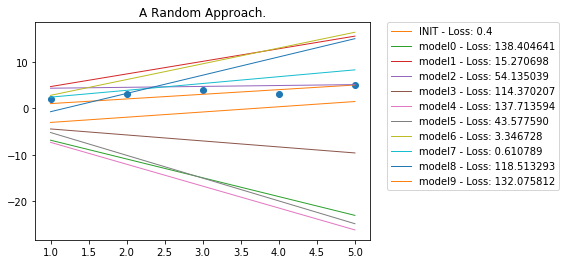

In [20]:
from helperFunc import plot2DModels
from linRegFunc import OLSLoss

# set a number of models to try
NUM_ITER = 10

# load & pre-process data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

# "training"
models = [[0,1]]
names = ["INIT - Loss: 0.4"]
best = {'loss':100, 'W': None}
for idx in range(NUM_ITER):
    # initialize a random weight vector  (|m|< 5 & |b|< 5)
    W = np.random.uniform(-5,5, size=(2))
    # compute loss & store for plotting
    loss = OLSLoss(X, y, W)
    models.append(W)
    names.append("model%s - Loss: %2f" % (idx, loss))
    # track best model
    if loss < best['loss']:
        best['loss'] = loss
        best['W'] = W
        
# results
print "Best Random Model: %s, Loss: %s" % (best["W"], best["loss"])
plot2DModels(points, models, names, "A Random Approach.")

So, that was pretty poor. One idea would be to run a lot more iterations.

> __DISCUSSION QUESTION:__ To what extent could parallelization help us redeem this approach? What exactly would you parallelize?

<a id=demo2></a>
## Demo: Systematic Brute Force.
[Return to Contents](#TOC) | [Skip to Appendix](#Appendix)

For obvious reasons a more systematic approach is desirable. Instead of randomly guessing, lets use what we know to search an appropriate section of the the model space.

We can tell from the data that the linear model should probably have a fairly shallow positive slope and a positive intercept between 0 and 2. So lets initialize every possible combination of weights in that range up to a granularity of, say $0.2$, and compute the loss for each one.

Best model: [ 1.6  0.6], Loss: 0.16


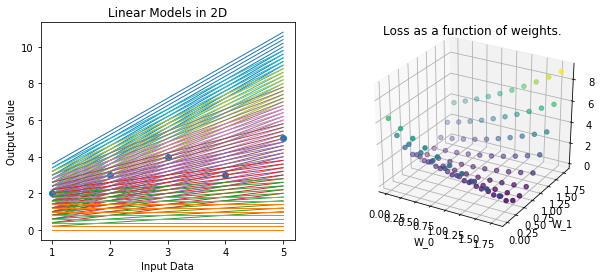

In [271]:
from helperFunc import plot3DLoss
from linRegFunc import OLSLoss

### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = augment(points)[:,:2]
y = points[:,1]

### "Training"
# simulate grid coordinates to act as our models
grid = np.mgrid[0:2:0.2,0:2:0.2].reshape(2,100).T

# compute loss
loss = []
for W in grid:
    loss.append(OLSLoss(X,y,W))
    
# take a look at the results
print "Best model: %s, Loss: %s" % (grid[np.argmin(loss)], min(loss))
plot3DLoss(points,grid,loss)

> __DISCUSSION QUESTION:__ When we think about scaling up, is this still a better approach than guessing? How could it be parallelized? What if we had higher dimension data?

<a id=TL1></a>
# Parameter Space, Gradients, and Convexity
[Return to Contents](#TOC) | [Skip to Appendix](#Appendix)

As suggested by the [systematic search demo](#demo2), when we train parametric models we tend to switch back and forth between two different ways of visualizing our goal.

<img src="domain_vs_parameter_space.png" width=400 height=400>

* When we look at a model next to our data represented in the Problem Domain Space, it is natural to think about loss as a measure of _**how far off the data are from our model**_. In other words, this visual suggests loss is a function of the training data $X$.
* By contrast, looking at an error surface plotted in Model Parameter Space, we intuitively see loss as an indicator of _**how far off the current model is from the optimal model**_. In other words, this view helps us think of loss as a function of the parameters $\theta$.

Of course in one sense, this distinction is just a matter of sematics. As we saw in equations 1.2, 1.3 and 1.4, MSE loss depends on _both_ the data and the parameters. However, in the context of 'inventing' ways to train a model, this distinction is a useful one. If we think of the data as fixed and focus on how loss varies _with respect to the parameters_, then we can take advantage of a little theory to speed up our search for the optimal parameters.

__Optimization Theory__

Calculus gives us the simple solution to optimizing a real function. The **First Order Conditions** (a.k.a. 'first derivative rule') says that the maximum or minimum of an unconstrained function must occur at a point where the first derivative = 0. In higher dimensions we extend this rule to talk about a **gradient** vector of partial derivatives which all must equal 0. 

When the first order partial derivatives are equal to zero, then we know we are at a local maximum or minimum of the real function.  But which one is it?  In order to tell, we must take the second derivatives of the real function.  If the second derivatives are positive at that point, then we know we are at a minimum.  If the second derivatives are negative, then we know we are at a maximum.  These are the **second order conditions.**

<img src="optimization.png" width=300 height=600>


__Convex Optimization__ is the lucky case where we know that the second derivatives never change sign. There are lots of complicated loss functions for which we can't easily visualize the error surface but for which we _can_ prove mathematically that this 2nd order condition is met. If this is the case, then we can think of the suface as _always curving up_ or _always curving down_ which guarantees that any minimum we reach will be an absolute minimum. 

> __DSICUSSION QUESTIONS:__ 
* In the case of Linear Regression performed on data $X \in \mathbb{R}^m$, how many dimensions does the gradient vector have? What do each of the values in this vector represent visually?
* If we are systematically searching the parameter space for a lowest point, why might it be useful to know that our loss function is convex? 
* In general (i.e. beyond Linear Regression) if finding the ideal parameters $\theta$, is as simple as solving the equation $f'(\theta)=0$, why don't we always train our models by solving that equation? 

<a id=demo3></a>
## Demo: Gradient Descent
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

To take advantage of these lessons from Optimization Theory, we'll start by taking the derivative of the loss function with respect to the parameters $\boldsymbol{\theta}$. Recall the matrix formulation of our loss function:

\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}

We can apply the sum and chain derivation rules to compute the gradient:

\begin{equation}\tag{3.1}
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right] \cdot \mathbf{x}'
\end{equation}

We _could_ now set this equation equal to $0$ and then solve for $\boldsymbol{\theta}$... but it turns out that this __closed form solution__ can be computationally challenging in higher dimensions. It also turns out that a simple approximation technique will work almost as well. 

The strategy of **Gradient Descent** is to start somewhere random in the Model Parameter Space and then move down the error surface to find a minimum point with the optimal parameters for our training data. Its ingeniousness is that we can do this without actually knowing the full shape of the error surface. Think of it like walking down a hill while blindfolded. You test each direction to see which way is down, then take a little step in that direction and repeat the process until you can't feel any more 'down' to go. The 'size' of our steps is controled by a hyperparameter, $\alpha$, the **learning rate**. The whole process can be summarized in 3 steps:
1. Initialize the parameters $\theta$.
2. Compute the gradient $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$.
3. Update the parameters: $\theta_{\text{new}} = \theta_{\text{old}} - \eta \cdot \nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) $  

We repeat these steps until we reach a stopping criteria.

> __A TASK FOR YOU:__ Compute one Gradent Descent update step for the small example from Part 2. 
Recall that our initial parameters were:
$$ \boldsymbol{\theta} = \begin{bmatrix} 1 \ \quad 0 \ \end{bmatrix}$$  


Hand Calculations:

|  $x_j '$  | $y_j$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_j$ | $\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_j - y_j\right]\cdot\mathbf{x}'_j$ |
|:----:|:-----:|:----------------:|:------------------------:|
|  input   | true y   |   predicted y   |  gradient  component for $x_j$       |
| $ \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}$   |  2   |                  |             |
| $ \begin{bmatrix} 2 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |
| $ \begin{bmatrix} 3 \\ 1 \\ \end{bmatrix}$   |  4   |                  |    |
| $ \begin{bmatrix} 4 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |
| $ \begin{bmatrix} 5 \\ 1 \\ \end{bmatrix}$   |  5   |                  |    |

The gradient $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$ for this data and these weights is: _______

If $\eta = 0.2$ the update for this step will be: _______

The new parameters will be $\theta_{\text{new}}=$ _______  

 > __DISCUSSION QUESTIONS:__  _How would you go about parallelizing this calculation? What would the mapper do, what would the reducers do? What key-value structure, sorting, partitioning, etc would you use? How does the computational demands of performing GD compare to the task of computing the loss?_ 

The supporting file `linRegFunc.py` includes a single core implementation of Linear Regression via Gradient Descent. Run the cell below to use that class to perform a few more iterations on this small data set. Note that this class does not use the augmented input vectors.

In [64]:
# import class from supporting file
from linRegFunc import Linear_Regression_Gradient_Descent_1D

# set hyperparameters
LEARNING_RATE = 0.05
REGULARIZATION_TYPE = None    # None, 'L1', or 'L2'
REGULARIZATION_FACTOR = 0.01
LOG_LEVEL = 0                 # 0, 1, or 2

# load & pre-process data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X_1d = points[:,0]
y_1d = points[:,1]

# Create a linear regression gradient descent class instance
lr_GD = Linear_Regression_Gradient_Descent_1D(max_iterations=200, stop_threshold=0.000005)

# Run the gradient descent algorithm for 1-dimensional data
lr_GD.run_linear_regression(X = X_1d,
                            y = y_1d, 
                            learning_rate=LEARNING_RATE,
                            reg_type=REGULARIZATION_TYPE,
                            reg_factor=REGULARIZATION_FACTOR,
                            log_level=LOG_LEVEL)

Start time: 2017-10-13 08:22:44
Stopping threshold reached.  Number of iterations = 196.
End time: 2017-10-13 08:22:44
Algorithm Elapsed Time: 0.00 minutes



In [65]:
# Look at model weights and loss
print "Final model parameters were:", lr_GD.weights
print "Loss for the final model:", lr_GD.r_squared()

Final model parameters were: [ 1.34774053  0.66987183]
Loss for the final model: 0.68117052487


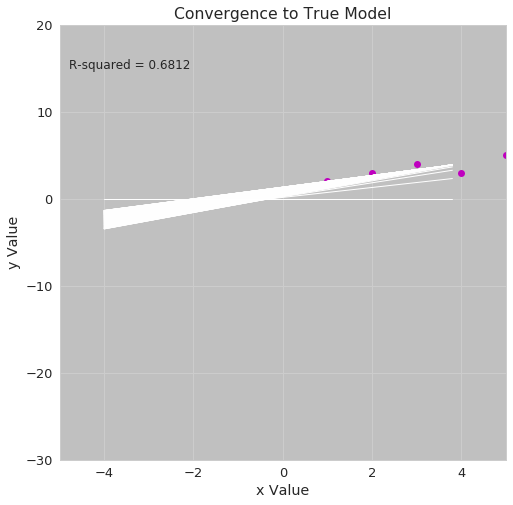

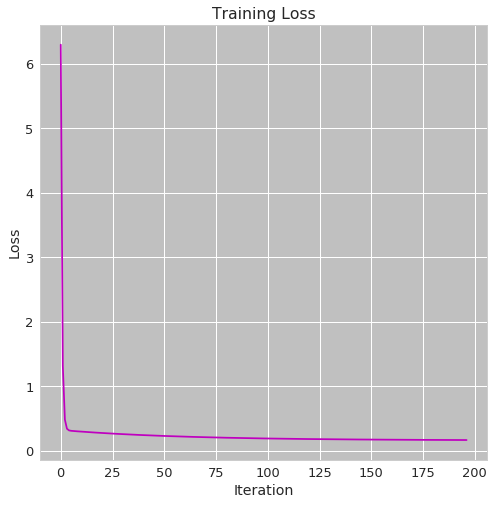

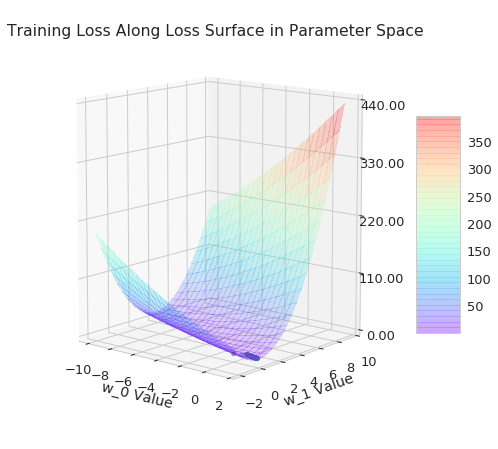

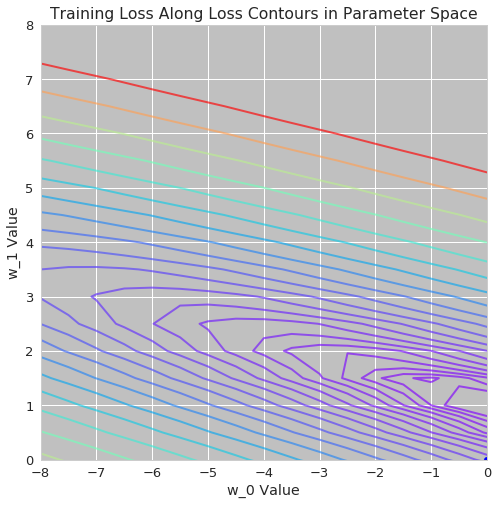

In [66]:
# Plot results in 4 graphs
lr_GD.plot_results()

<a id=demo5></a>
## Demo : Stoichastic Gradient Descent
[Return to Contents](#TOC) | [Skip to Appendix](#Appendix)

In Full GD we do a descent step only after the calculation of the gradient over the whole set of data. In this case the gradient is precise and gives the best possible direction. But it can require quite a lot of time if we have huge amounts of data. 

In practice we can get faster convergence if we calculate the gradient not over the whole set of data but over the small (size of $B$) **batch** of it.

$$
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
$$
where $a_i$ is an array of indices of objects which are in this batch. Common approach here that you should use is to shuffle samples randomly and then iterate over them with batches.

So with this batch approach we get an approximation of the real gradient in point $\boldsymbol{\theta}$. This approximation is very cheap and fast to compute (usually $B$ is not too big $-$ from 32 to 256). After obtaining this gradient we do a descent step in this approximate direction and proceed to the next stage of batch descent.

> __A TASK FOR YOU:__ Perform 5 update steps of Stoichastic Gradient Descent with batchsize = $1$ on our small data set. 
Recall that our initial parameters were:
$$ \boldsymbol{\theta} = \begin{bmatrix} 1 \ \quad 0 \ \end{bmatrix}$$  


Hand Calculations:

|  $x_j '$  | $y_j$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_j$ | $\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_j - y_j\right]\cdot\mathbf{x}'_j$ | $\eta \nabla_{\boldsymbol{\theta}} f$ | $\boldsymbol(\theta) - \eta \nabla_{\boldsymbol{\theta}} f $ |
|:----:|:-----:|:----------------:|:------------------------:|:--------------:|:-----------:|
|  input   | true y   |   predicted y   | gradient for this 'batch' | update | new parameters|
| $ \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}$   |  2   |                  |             | | |
| $ \begin{bmatrix} 2 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |  |  |
| $ \begin{bmatrix} 3 \\ 1 \\ \end{bmatrix}$   |  4   |                  |    |  |  |
| $ \begin{bmatrix} 4 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |  |  |
| $ \begin{bmatrix} 5 \\ 1 \\ \end{bmatrix}$   |  5   |                  |    |  |  |

 > __DISCUSSION QUESTIONS:__  _How does this result compare to our result from the hand calculations in the last section? What implications does this have for our quest to find the optimal paramters?_ 

<a id=big_ex></a>
# A Bigger Example
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

Ok, now that we have a handle on the math and the basic design choices involved in implementing & parallelizing Gradient Descent. Lets look at a slightly bigger example: the boston housing prices dataset.

In [23]:
# ML modules
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

/opt/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
# set style for plotting
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

In [27]:
# we'll also fix the random see for reproducibility
np.random.seed(42)

## Boston House Prices Dataset

Boston dataset is extremely common in machine learning experiments thus it is embedded in sklearn. Run the next few cells to load the data and become familiar with it.

In [30]:
# Load the data & take a look.
from sklearn.datasets import load_boston
boston = load_boston()

In [29]:
# OPTIONAL - view description
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [31]:
# Create data frame & test/train split.
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Take a look
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Exploratory Data Analysis

Before we jump into our linear regression, its good to become familiar with the variables you will be modeling.

In [283]:
# Summary statistics
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Note that some of the features are catecorical and some are continious.

Let's also take a look at a correlation matrix of features.

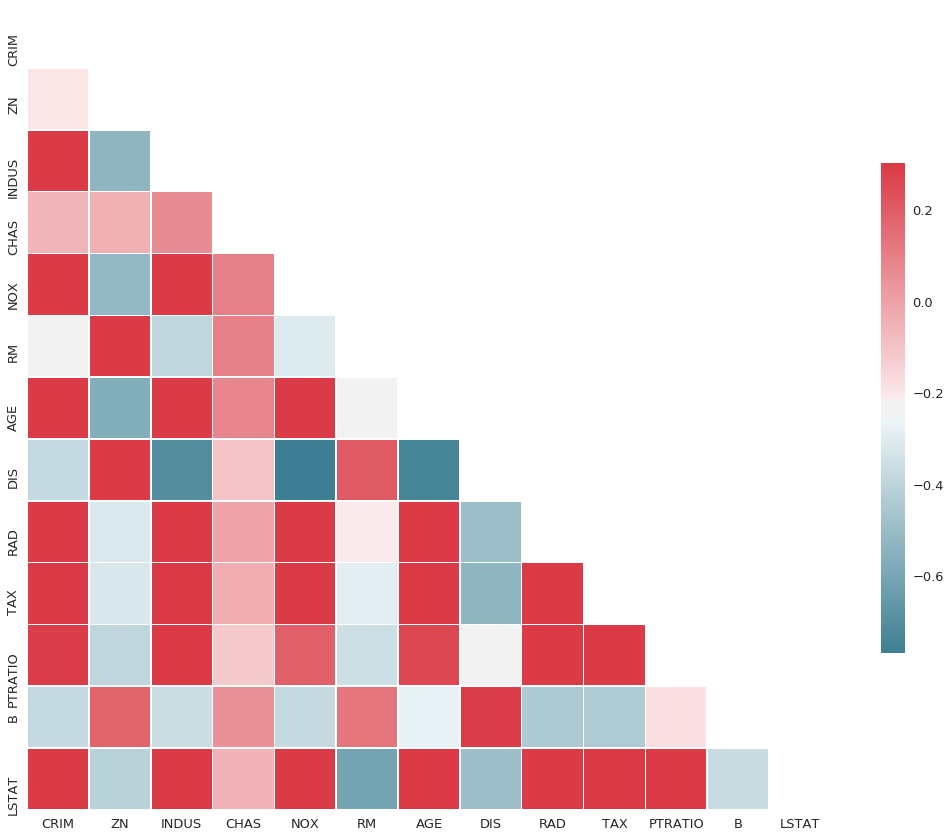

In [33]:
# compute the correlation matrix
corr = X.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.show()

## Scaling

Once we start performing gradient descent on real world data, a few additional concerns arise. 

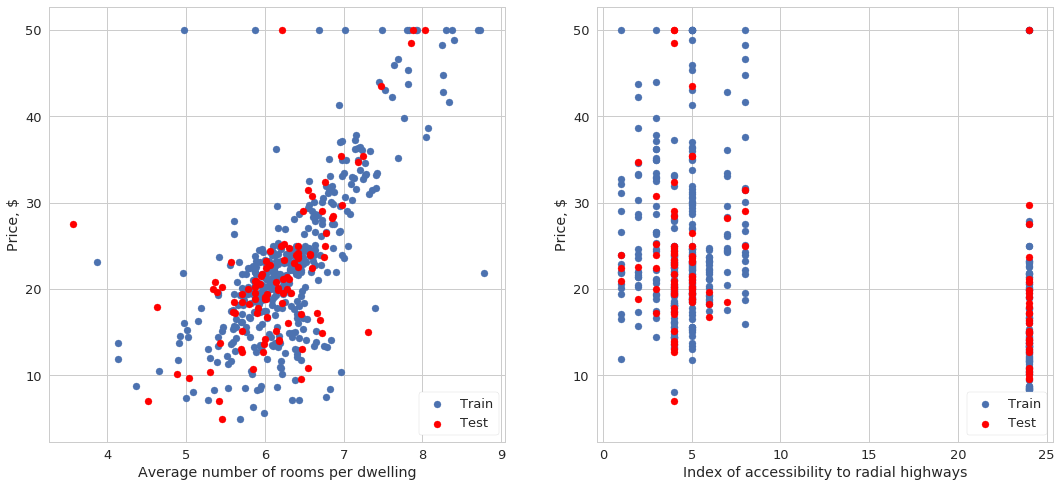

In [34]:
# Lets visualize two of the features from the Boston Dataset
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_train.RM, y_train, label="Train")
plt.scatter(X_test.RM, y_test, c="r", label="Test")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train.RAD, y_train, label="Train")
plt.scatter(X_test.RAD, y_test, c="r", label="Test")
plt.xlabel("Index of accessibility to radial highways")
plt.ylabel("Price, $")
plt.legend(loc="lower right")
plt.show()

> __DISCUSSION QUESTION:__ What will happen in the Gradient Descent update step when you have input variables that are measured on very different scales? What could we do to avoid this problem?

As you probably realized, the easiest solution is to perform normalization before we start modeling. Here we'll normalize each feature so that all $x_{ji} \in (0,1)$.

In [35]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

Note that we're going to learn normalization constants only on training set. That's done because the assumption is that test set is unreachable during training. However once we've got our normalization functions, we'll also aply them to the test set.

In [36]:
X_test = scaler.transform(X_test)

<a id=demo7></a>
# Sklearn Linear Regression
[Return to Contents](#TOC) | [Skip to Appendix](#Appendix)

Here we use very simple Linear Regression model. Scikit-learn uses the closed-form solition for Linear Regression problem thus it gives very good results.

## Fitting

In [37]:
# initialize the model
model_sk = LinearRegression()

# fit the data
model_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
# run our model to predict the test and train sets for evaluation
preds_test = model_sk.predict(X_test)
preds_train = model_sk.predict(X_train)

## Evaluation

Let's see what features are significant for the model

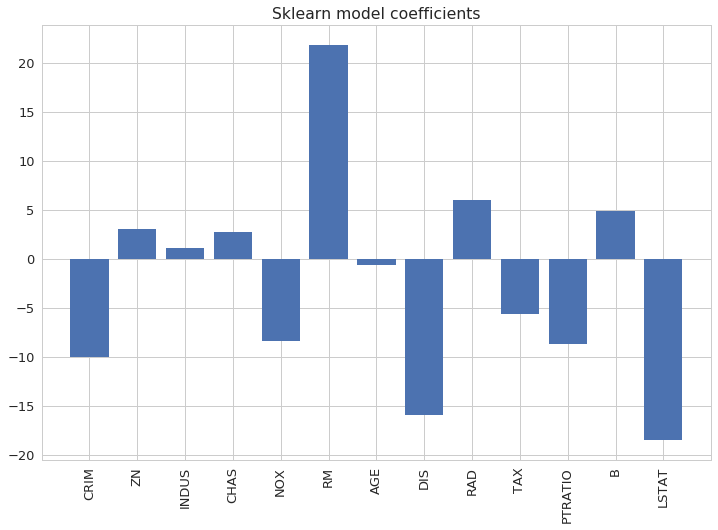

In [38]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_sk.coef_.shape[0]), model_sk.coef_)
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Sklearn model coefficients")
plt.show()

Next we'll evaluate our model according to three different metrics: 
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* MAPE (Mean Absolute Percentage Error)

Note that there is no MAPE implementation in sklearn & that this is a problematic metric because it is prone to ZeroDivisionErrors. However for today's illustration we have included a custom implementation in the supplemental file `linRegFunc.py`. You can find it in the [Appendix](#appendix).

In [43]:
# define a function
def evaluate(models, metrics, samples, metrics_names, models_names):
    """
    This function runs Linear Regression Evaluation metrics 
    by looping over a provided set of models and datasets.
    """
    results = np.zeros((len(samples) * len(models), len(metrics)))
    samples_names = []
    for m in models_names:
        samples_names.extend([m + " Train", m + " Test"])
    for m_num, model in enumerate(models):
        for row, sample in enumerate(samples):
            for col, metric in enumerate(metrics):
                results[row + m_num * 2, col] = metric(sample[1], model.predict(sample[0]))
    results = pd.DataFrame(results, columns=metrics_names, index=samples_names)
    return results

In [46]:
# define metrics to run
metrics = [mean_absolute_error, 
           lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5, 
           linRegFunc.mean_absolute_percentage_error]
metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]

# define data sets & models to run on
samples = [(X_train, y_train), 
           (X_test, y_test)]
models_names = ["Sklearn"]
models = [model_sk]

In [47]:
# function call
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585


It also interesting to take a look how the predicted points relate to real ones. All the points should lie on the black dotted line ($y=x$) assuming that our model is perfect.

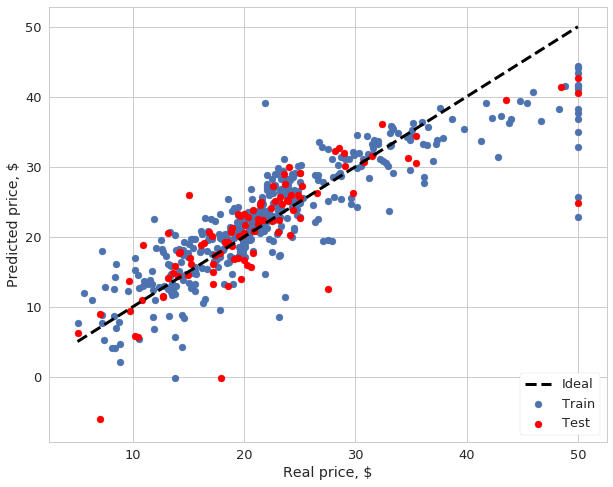

In [50]:
plt.figure(figsize=(10, 8))
plt.scatter(y_train, preds_train, label="Train")
plt.scatter(y_test, preds_test, c="r", label="Test")
plt.xlabel("Real price, $")
plt.ylabel("Predicted price, $")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, label="Ideal")
plt.legend(loc="lower right")
plt.show()

## Cross-validation

The common method to evaluate the model is cross-validation. The idea behind it is to divide the whole set of objects into $k$ sections and then use one section as a test set and other $k-1$ as a train (repeat it with all the sections).

There is a special function for this in sklearn called $\text{KFold}$. It creates set of indices for cross-validation.

In [28]:
cv = KFold(n=len(X), n_folds=5, shuffle=True, random_state=42)

Next step is to do everything that we've done before in a loop:
* Split
* Scale
* Train
* Evaluate

And store the average value of the errors ($\text{res}$ variable)

In [29]:
res = None
for train_idx, test_idx in cv:
    # split
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # scale
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    samples_cv = [(X_train, y_train), 
                  (X_test, y_test)]
    
    # fit
    model_sk_cv = LinearRegression().fit(samples_cv[0][0], samples_cv[0][1])
    
    # evaluate
    if res is None:
        res = evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
    else:
        res += evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
# take the average value across all folds
res /= cv.n_folds

Here is the result of CV

In [30]:
res

,MAE,RMSE,MAPE
Sklearn CV Train,3.269853,4.660627,16.423244
Sklearn CV Test,3.390748,4.843271,17.026372


# Homegrown Linear Regresssion

In this section we'll write our own Linear Regression class that performs gradient descent. This class will use numpy for efficient matrix calculations. Recall that the matrix representation of our loss functions is: 

$$
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
$$

Then the gradient can be easily calculated in vectorized form:

$$
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\text{X}'^{\text{T}}\left(\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\right)
$$

Exactly these computations are implemented down below in **BasicLinearRegressionHomegrown** class

In [92]:
class BasicLinearRegressionHomegrown(object):
    
    def __init__(self):
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": [], 
                        "grad": []}
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        return gradient
    
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha=0.0005):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        # do full gradient descent
        self._gd(X, y, max_iter)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
    def score(self, X, y):
        """
        Calculate RMSE metric

        Args:
            X(ndarray):      objects
            y(ndarray):      answers
        Return:
            rmse(float):     RMSE
        """
        pred = self.predict(X)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5
        return rmse
        
    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        return pred## Stochastic Gradient Descent
* Implement stochastic gradient descent algorithm as a member of a class
* Check that analytical gradient is right via numerical gradient function from **TweakedLinearRegressionHomegrown**

In Full GD we do a descent step only after the calculation of the gradient over the whole set of data. In this case the gradient is precise and gives the best possible direction. But it can require quite a lot of time if we have huge amounts of data. 

In practice we can get faster convergence if we calculate the gradient not over the whole set of data but over the small (size of $B$) **batch** of it.

$$
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
$$
where $a_i$ is an array of indices of objects which are in this batch. Common approach here that you should use is to shuffle samples randomly and then iterate over them with batches.

So with this batch approach we get an approximation of the real gradient in point $\boldsymbol{\theta}$. This approximation is very cheap and fast to compute (usually $B$ is not too big $-$ from 32 to 256). After obtaining this gradient we do a descent step in this approximate direction and proceed to the next stage of batch descent.

class StochasticLinearRegressionHomegrown(TweakedLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(StochasticLinearRegressionHomegrown, self).__init__()
    
    def _sgd(self, X, y, max_iter, batch_size, alpha=0.0005):
        """
        Runs Stochastic GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        
        for epoch in range(max_iter):
            idxs = np.random.permutation(X.shape[0])
            X = X[idxs]
            y = y[idxs]
            for i in range(0, len(X), batch_size):
                
                self.history["coef"].append(self._theta[1:].copy())
                self.history["intercept"].append(self._theta[0].copy())
                
                rmse = self.score(X, y)
                self.history["cost"].append(rmse)
                
                # calculate gradient
                grad = self._grad(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad"].append(grad)
                
                # numerical gradient
                grad_num = self._grad_num(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad_num"].append(grad_num)
            
                # do gradient step
                self._theta -= alpha * grad
        
    def fit(self, X, y, max_iter=1000, batch_size=16):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
        Return:
            self
        """
        X = np.c_[np.ones(X.shape[0]), X]
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])

        self._sgd(X, y, max_iter, batch_size)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]

Create model

model_homegrown_sgd = StochasticLinearRegressionHomegrown()

Fitting

model_homegrown_sgd.fit(X_train, y_train, max_iter=1500)

plt.figure(figsize=(10, 8))
plt.plot(model_homegrown_sgd.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Stochastic Gradient Descent")
plt.legend(frameon=True)
plt.show()

Plotting error curves

grad_num = np.array(model_homegrown_sgd.history["grad_num"])
grad = np.array(model_homegrown_sgd.history["grad"])

plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

Evaluation

models = [model_sk, model_homegrown, model_homegrown_sgd]
models_names = ["Sklearn", "Homegrown Full GD", "Homegrown SGD"]

evaluate(models, metrics, samples, metrics_names, models_names)

## L1 and L2 regularization for Linear Regression
Regularization is a way of penalizing the model for excessive complexity. It allows to avoid overfitting.

There are many ways of doing regularization but these two are the major ones:
* **L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}w_j^2
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_2^2
$$
* **L1-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}|w_j|
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1
$$

Try to encorporate both of them into the GD solution of Linear Regression starting with L2-regularization. What is the problem then with L1-regularization? What benefits L1 can gives apart from reducing overfitting.

class RegularizedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self, l1_reg=0.0, l2_reg=0.0):
        # call the constructor of the parent class
        super(RegularizedLinearRegressionHomegrown, self).__init__()
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function 
        with L1 and L2 regularizations

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        # penalties only for weights
        gradient[1:] += 2 * self.l2_reg * self._theta[1:] + self.l1_reg * np.sign(self._theta[1:])
        return gradient

Create model

model_homegrown_regularized_l2 = RegularizedLinearRegressionHomegrown(l1_reg=0.0, l2_reg=0.1)
model_homegrown_regularized_l1 = RegularizedLinearRegressionHomegrown(l1_reg=1.0, l2_reg=0.0)

Fitting

model_homegrown_regularized_l2.fit(X_train, y_train, max_iter=40000)
model_homegrown_regularized_l1.fit(X_train, y_train, max_iter=40000)

Evaluation

models = [model_sk, model_homegrown, model_homegrown_regularized_l2, model_homegrown_regularized_l1]
models_names = ["Sklearn", "Homegrown", "Homegrown Regularized L2", "Homegrown Regularized L1"]

evaluate(models, metrics, samples, metrics_names, models_names)

Comparison of regularized models

plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_homegrown.coef_.shape[0]) - 0.2, model_homegrown.coef_, width=0.2, label="No reg")
plt.bar(np.arange(model_homegrown_regularized_l2.coef_.shape[0]), model_homegrown_regularized_l2.coef_, width=0.2, label="L2")
plt.bar(np.arange(model_homegrown_regularized_l1.coef_.shape[0]) + 0.2, model_homegrown_regularized_l1.coef_, width=0.2, label="L1")
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Model coefficients comparison")
plt.legend()
plt.show()

print("2-norm of weights:\n")
print("{:10s}{:.2f}".format("No reg:", np.linalg.norm(model_homegrown.coef_)))
print("{:10s}{:.2f}".format("L2:", np.linalg.norm(model_homegrown_regularized_l2.coef_)))
print("{:10s}{:.2f}".format("L1:", np.linalg.norm(model_homegrown_regularized_l1.coef_)))

print("Number of non-zero coefficients:\n")
print("{:10s}{:d}".format("No reg:", np.sum(np.abs(model_homegrown.coef_) > 1e-2)))
print("{:10s}{:d}".format("L2:", np.sum(np.abs(model_homegrown_regularized_l2.coef_) > 1e-2)))
print("{:10s}{:d}".format("L1:", np.sum(np.abs(model_homegrown_regularized_l1.coef_) > 1e-2)))

As one can notice L2-regularization greatly reduces the 2-norm of weight vector thereby it prevents overfitting. Regularization constant can be used to control [bias-variance tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html).

L1-regularization plays the same role but it also has one very important prorepty: it can work as a feature selector (impose sparsity on the coefficient vector). From mathematical perspective it can be explained as follows: L1-norm is the "closest" approximation to the L0-norm which explicitly equals to the number of non-zero elements. For sure, the ideal feature selector is L0-norm but one can not simply minimize it because of its computationally intractability (due to its combinatorial nature). Thus people usually use L1-norm for that purpose. More intuitive geometrical interpretation can be found [here](https://www.quora.com/Why-is-L1-regularization-supposed-to-lead-to-sparsity-than-L2) or in any other source (lots of them). For more detailed and deep mathematical explanation one can take a look into [compressed sensing](https://en.wikipedia.org/wiki/Compressed_sensing) method introduced by Terence Tao and David Donoho in the early 2000's.

__Create model__

In [93]:
model_homegrown = BasicLinearRegressionHomegrown()

__Fitting__

In [94]:
model_homegrown.fit(X_train, y_train, max_iter=40000)

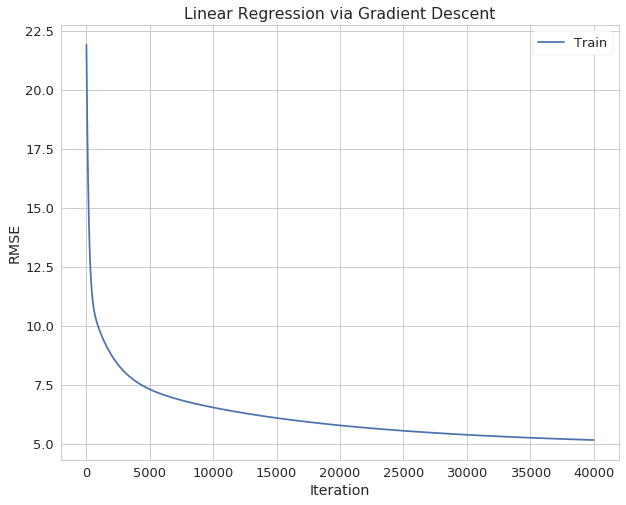

In [95]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent")
plt.legend()
plt.show()

__Evaluation__

In [96]:
models = [model_sk, model_homegrown]
models_names = ["Sklearn", "Homegrown"]

In [97]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Train,3.569153,5.158088,17.505427
Homegrown Test,3.398129,5.325236,18.293927


## Numerical check
* **BasicLinearRegressionHomegrown** class provides you with the method *_grad* that allows to compute analytical gradient. This function is correct
* Inheret from this class and implement a method for numerical approximation of gradient (see placeholder below)
* Check your function by comparing with the analytical one. They **should** be similar.
* Plot the difference of analytical and numerical gradients and describe what you observe

The formula for analytical gradient (from calculus):

$$
\nabla f(\mathbf{x}) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1}\\
\vdots\\
\frac{\partial f}{\partial x_m}
\end{bmatrix}, \text{ where } m \text{ is the space dimension}\\
\frac{\partial f}{\partial x_1} = \lim_{\alpha \rightarrow 0} \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha}
$$

For sufficiently small $\alpha$ one can approximate partial derivative by simple throwing out the limit operator

$$
\frac{\partial f}{\partial x_1} \approx \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha} = \left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
$$

Then the final approximation of the gradient is:

$$
\nabla f(\mathbf{x}) \approx \nabla_{\text{num}\,\,} f(\mathbf{x}) = \begin{bmatrix}
\left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
\vdots\\
\left( \frac{\partial f}{\partial x_m} \right)_{\text{num}}
\end{bmatrix}
$$

The common way of measuring the difference between vectors is the following:
$$
\text{er} = \frac{\|\nabla f(\mathbf{x}) - \nabla_{\text{num}\,\,}f(\mathbf{x})\|_2^2}{\|\nabla f(\mathbf{x})\|_2^2} = \frac{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x}) - \nabla^j_{\text{num}\,\,}f(\mathbf{x})\right)^2}{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x})\right)^2}
$$

In [98]:
class TweakedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(TweakedLinearRegressionHomegrown, self).__init__()
        self.history["grad_num"] = []
        
    @staticmethod
    def _gradient_approximation(f, x):
        """
        Returns the numerical gradient of the function f at the point x

        Args:
            f(callable): function that takes the point x as an input 
                         and returns the value of the function
            x(ndarray): numpy array which contains the coordinates 
                        of the point to evaluate gradient
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """

        grad_num = np.zeros(len(x))

        alpha = 0.001
        for i in range(len(x)):
            h = np.zeros(len(x))
            h[i] += alpha
            grad_num[i] = (f(x + h) - f(x)) / alpha

        return grad_num
    
    def _grad_num(self, X, y):
        """
        Returns the numerical gradient of the LinearRegression 
        objective function

        Args:
            X(ndarray): train objects
            y(ndarray): answers for train objects
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """
        
        grad_num = np.zeros(X.shape[1])
        
        def f(a):
            pred = np.dot(X, a)
            error = pred - y
            mse = np.mean(error ** 2)
            return mse
            
        
        grad_num = self._gradient_approximation(f, self._theta)
        
        return grad_num
    
    def _gd(self, X, y, max_iter, alpha=0.001):
        """
        Runs GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            grad_num = self._grad_num(X, y)
            self.history["grad_num"].append(grad_num)
            
            self._theta -= alpha * grad

Create model

In [99]:
model_homegrown_check_grad = TweakedLinearRegressionHomegrown()

Fitting

In [100]:
model_homegrown_check_grad.fit(X_train, y_train, max_iter=40000)

Plotting error curves

In [101]:
grad_num = np.array(model_homegrown_check_grad.history["grad_num"])
grad = np.array(model_homegrown_check_grad.history["grad"])

In [102]:
def relative_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1. / np.sum(grad ** 2, axis=1)

In [103]:
def absolute_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1.

In [104]:
pd.DataFrame(absolute_error(grad, grad_num)).describe()

,0
count,4.000000e+04
mean,2.543207e-06
std,3.530528e-14
min,2.543206e-06
25%,2.543207e-06
50%,2.543207e-06
75%,2.543207e-06
max,2.543207e-06


In [105]:
absolute_error(grad, grad_num)[:2]

array([  2.54320658e-06,   2.54320628e-06])

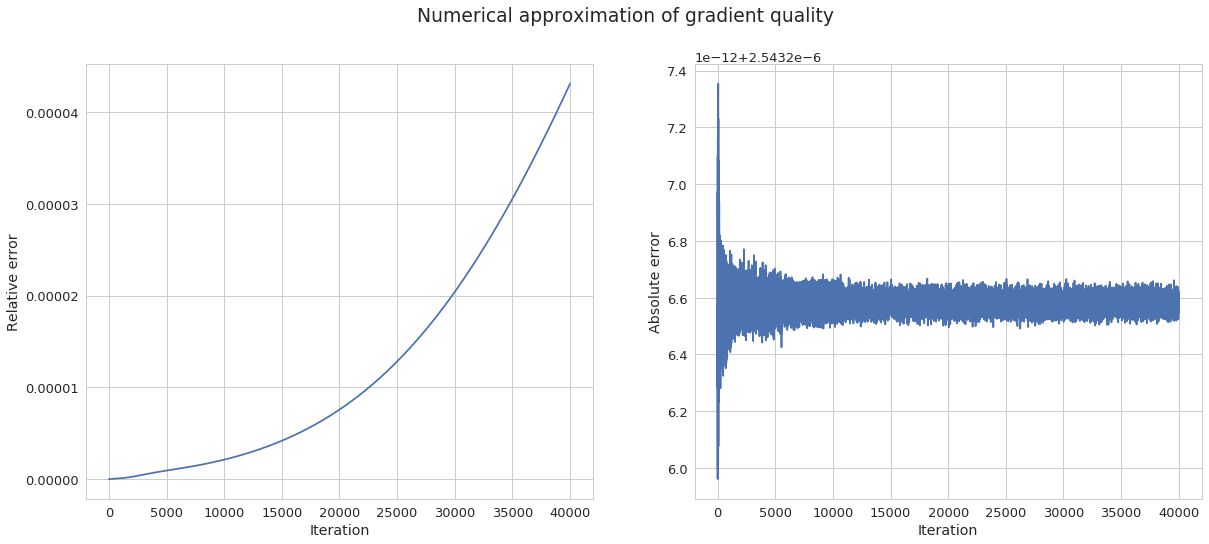

In [106]:
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

As one can observe absolute error jitters but remains approximately the same during all the trining process. The big values in the beginning is due to the fact that the values of gradient is also big.

Relative error grows because the norm of the gradient (which is in the denominator) becomes smaller while the optimization process converges.

## Stochastic Gradient Descent
* Implement stochastic gradient descent algorithm as a member of a class
* Check that analytical gradient is right via numerical gradient function from **TweakedLinearRegressionHomegrown**

In Full GD we do a descent step only after the calculation of the gradient over the whole set of data. In this case the gradient is precise and gives the best possible direction. But it can require quite a lot of time if we have huge amounts of data. 

In practice we can get faster convergence if we calculate the gradient not over the whole set of data but over the small (size of $B$) **batch** of it.

$$
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
$$
where $a_i$ is an array of indices of objects which are in this batch. Common approach here that you should use is to shuffle samples randomly and then iterate over them with batches.

So with this batch approach we get an approximation of the real gradient in point $\boldsymbol{\theta}$. This approximation is very cheap and fast to compute (usually $B$ is not too big $-$ from 32 to 256). After obtaining this gradient we do a descent step in this approximate direction and proceed to the next stage of batch descent.

In [107]:
class StochasticLinearRegressionHomegrown(TweakedLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(StochasticLinearRegressionHomegrown, self).__init__()
    
    def _sgd(self, X, y, max_iter, batch_size, alpha=0.0005):
        """
        Runs Stochastic GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        
        for epoch in range(max_iter):
            idxs = np.random.permutation(X.shape[0])
            X = X[idxs]
            y = y[idxs]
            for i in range(0, len(X), batch_size):
                
                self.history["coef"].append(self._theta[1:].copy())
                self.history["intercept"].append(self._theta[0].copy())
                
                rmse = self.score(X, y)
                self.history["cost"].append(rmse)
                
                # calculate gradient
                grad = self._grad(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad"].append(grad)
                
                # numerical gradient
                grad_num = self._grad_num(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad_num"].append(grad_num)
            
                # do gradient step
                self._theta -= alpha * grad
        
    def fit(self, X, y, max_iter=1000, batch_size=16):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
        Return:
            self
        """
        X = np.c_[np.ones(X.shape[0]), X]
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])

        self._sgd(X, y, max_iter, batch_size)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]

Create model

In [108]:
model_homegrown_sgd = StochasticLinearRegressionHomegrown()

Fitting

In [109]:
model_homegrown_sgd.fit(X_train, y_train, max_iter=1500)

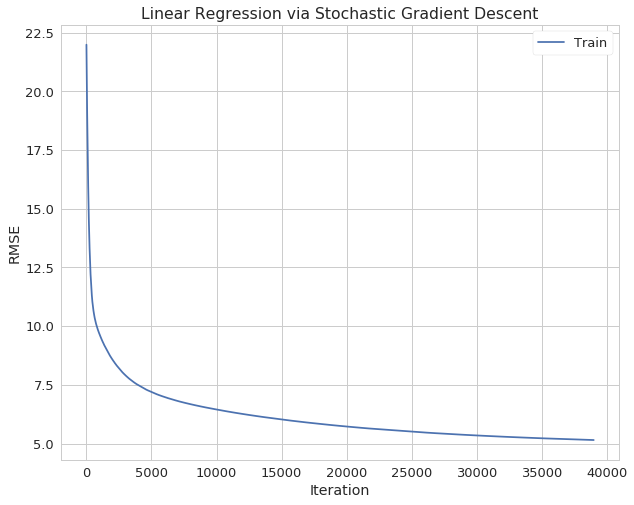

In [110]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown_sgd.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Stochastic Gradient Descent")
plt.legend(frameon=True)
plt.show()

Plotting error curves

In [111]:
grad_num = np.array(model_homegrown_sgd.history["grad_num"])
grad = np.array(model_homegrown_sgd.history["grad"])

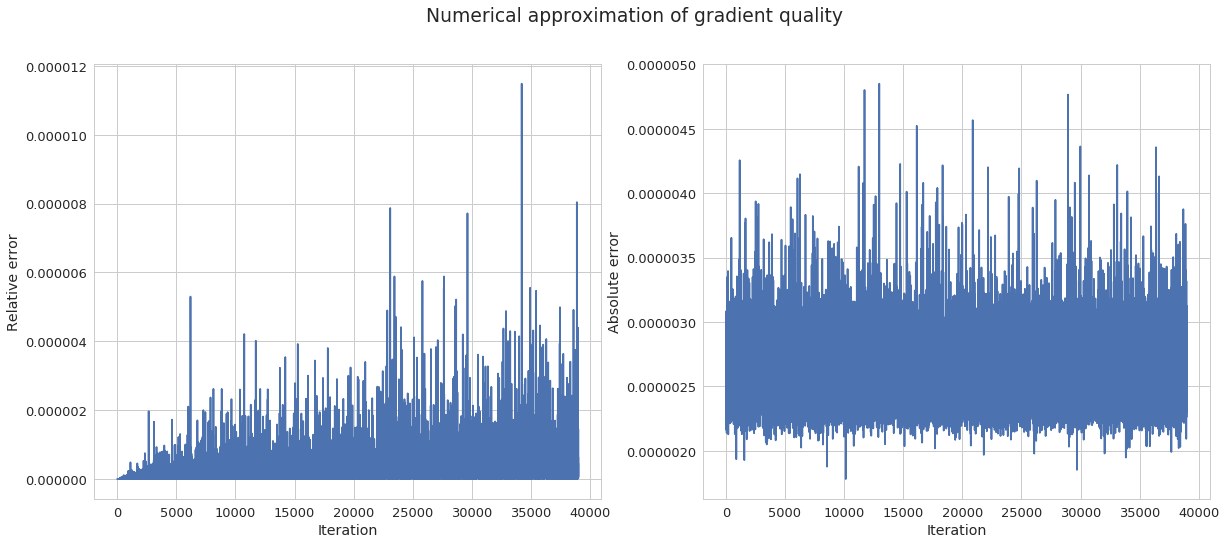

In [112]:
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

Evaluation

In [113]:
models = [model_sk, model_homegrown, model_homegrown_sgd]
models_names = ["Sklearn", "Homegrown Full GD", "Homegrown SGD"]

In [114]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Full GD Train,3.569153,5.158088,17.505427
Homegrown Full GD Test,3.398129,5.325236,18.293927
Homegrown SGD Train,3.559724,5.148235,17.385061
Homegrown SGD Test,3.386664,5.314391,18.202062


## L1 and L2 regularization for Linear Regression
Regularization is a way of penalizing the model for excessive complexity. It allows to avoid overfitting.

There are many ways of doing regularization but these two are the major ones:
* **L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}w_j^2
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_2^2
$$
* **L1-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}|w_j|
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1
$$

Try to encorporate both of them into the GD solution of Linear Regression starting with L2-regularization. What is the problem then with L1-regularization? What benefits L1 can gives apart from reducing overfitting.

In [115]:
class RegularizedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self, l1_reg=0.0, l2_reg=0.0):
        # call the constructor of the parent class
        super(RegularizedLinearRegressionHomegrown, self).__init__()
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function 
        with L1 and L2 regularizations

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        # penalties only for weights
        gradient[1:] += 2 * self.l2_reg * self._theta[1:] + self.l1_reg * np.sign(self._theta[1:])
        return gradient

Create model

In [116]:
model_homegrown_regularized_l2 = RegularizedLinearRegressionHomegrown(l1_reg=0.0, l2_reg=0.1)
model_homegrown_regularized_l1 = RegularizedLinearRegressionHomegrown(l1_reg=1.0, l2_reg=0.0)

Fitting

In [117]:
model_homegrown_regularized_l2.fit(X_train, y_train, max_iter=40000)
model_homegrown_regularized_l1.fit(X_train, y_train, max_iter=40000)

Evaluation

In [118]:
models = [model_sk, model_homegrown, model_homegrown_regularized_l2, model_homegrown_regularized_l1]
models_names = ["Sklearn", "Homegrown", "Homegrown Regularized L2", "Homegrown Regularized L1"]

In [119]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Train,3.569153,5.158088,17.505427
Homegrown Test,3.398129,5.325236,18.293927
Homegrown Regularized L2 Train,4.615012,6.613793,22.367031
Homegrown Regularized L2 Test,4.044824,6.050886,21.441803
Homegrown Regularized L1 Train,4.497009,6.411183,22.798440
Homegrown Regularized L1 Test,4.048352,6.066900,22.103592


Comparison of regularized models

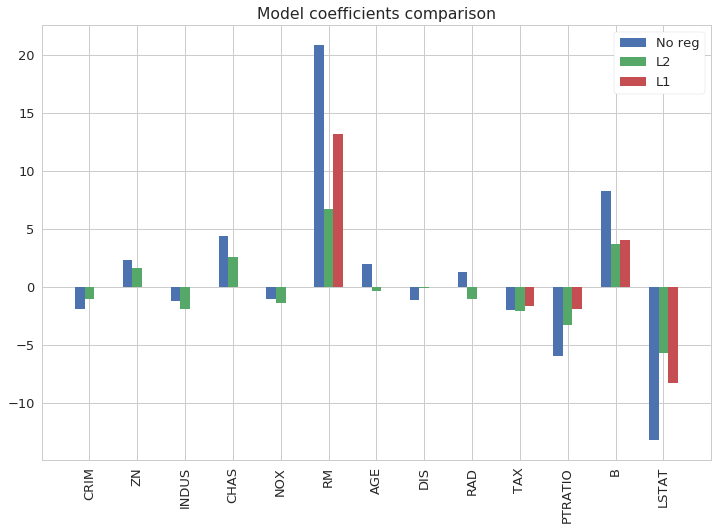

In [120]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_homegrown.coef_.shape[0]) - 0.2, model_homegrown.coef_, width=0.2, label="No reg")
plt.bar(np.arange(model_homegrown_regularized_l2.coef_.shape[0]), model_homegrown_regularized_l2.coef_, width=0.2, label="L2")
plt.bar(np.arange(model_homegrown_regularized_l1.coef_.shape[0]) + 0.2, model_homegrown_regularized_l1.coef_, width=0.2, label="L1")
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Model coefficients comparison")
plt.legend()
plt.show()

In [121]:
print("2-norm of weights:\n")
print("{:10s}{:.2f}".format("No reg:", np.linalg.norm(model_homegrown.coef_)))
print("{:10s}{:.2f}".format("L2:", np.linalg.norm(model_homegrown_regularized_l2.coef_)))
print("{:10s}{:.2f}".format("L1:", np.linalg.norm(model_homegrown_regularized_l1.coef_)))

2-norm of weights:

No reg:   27.46
L2:       11.12
L1:       16.26


In [122]:
print("Number of non-zero coefficients:\n")
print("{:10s}{:d}".format("No reg:", np.sum(np.abs(model_homegrown.coef_) > 1e-2)))
print("{:10s}{:d}".format("L2:", np.sum(np.abs(model_homegrown_regularized_l2.coef_) > 1e-2)))
print("{:10s}{:d}".format("L1:", np.sum(np.abs(model_homegrown_regularized_l1.coef_) > 1e-2)))

Number of non-zero coefficients:

No reg:   13
L2:       13
L1:       5


As one can notice L2-regularization greatly reduces the 2-norm of weight vector thereby it prevents overfitting. Regularization constant can be used to control [bias-variance tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html).

L1-regularization plays the same role but it also has one very important prorepty: it can work as a feature selector (impose sparsity on the coefficient vector). From mathematical perspective it can be explained as follows: L1-norm is the "closest" approximation to the L0-norm which explicitly equals to the number of non-zero elements. For sure, the ideal feature selector is L0-norm but one can not simply minimize it because of its computationally intractability (due to its combinatorial nature). Thus people usually use L1-norm for that purpose. More intuitive geometrical interpretation can be found [here](https://www.quora.com/Why-is-L1-regularization-supposed-to-lead-to-sparsity-than-L2) or in any other source (lots of them). For more detailed and deep mathematical explanation one can take a look into [compressed sensing](https://en.wikipedia.org/wiki/Compressed_sensing) method introduced by Terence Tao and David Donoho in the early 2000's.

# Linear Regression in MR Job
There are three different ways to write the MRJob class for gradient descent:

1.  Standard mapper and reducer
2.  Standard mapper and reducer with a combiner
3.  In-mapper combining with a reducer

The in-mapper combining is the most efficient because it keeps data from having to be passed across the network.  It is possible because the partial gradient vector is only as long as the number of features, which is usually of a manageable size that can be held in memory.  We present the in-memory mapper version of the MRJob class below.  

Also note that the weights file must be read in for both the mapper and the reducer phases.

## MR Job for batch GD

In [125]:
%%writefile MrJobBatchGD_LinearRegression.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import numpy as np
"""
This MrJob calculates the gradient of the entire training set 
Mapper: Calculates partial gradient for each example.  Uses in-mapper combining.
"""

class MrJobBatchGD_LinearRegression(MRJob):

    
    # Allow import of the weights file name, the regularization type, and the regularization factor
    def configure_options(self):
        super(MrJobBatchGD_LinearRegression, self).configure_options()
        self.add_passthrough_option('--weights_file', type='str', help='Weights File for Uploading')
        self.add_passthrough_option('--reg_type', type='str', help='Regularization Type')
        self.add_passthrough_option('--reg_factor', type='str', help='Regularization Factor')
        return
    
    # Read in the weights before the mapper processes any input
    def read_weightsfile(self):
        # Read weights file
        with open(self.options.weights_file, 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialize gradient for this iteration
        self.partial_gradient = [0]*len(self.weights)
        self.partial_count = 0
    
    # Calculate partial gradient for each example 
    def partial_gradient(self, _, line):
        inputs = (map(float,line.split(',')))
        y = inputs[1]
        x = inputs[2:]
        # y_hat is the predicted value given current weights
        y_hat = 1.0*self.weights[0] + np.dot(np.array(self.weights[1:]), np.array(x))
        # Update partial gradient vector with gradient from current example
        self.partial_gradient[0] += (y - y_hat)*(-1)
        for i in range(len(x)):
            self.partial_gradient[i + 1] += (y - y_hat)*(-x[i])
        # Update count
        self.partial_count = self.partial_count + 1
        return
    
    # Finally emit in-memory partial gradient and partial count
    def partial_gradient_emit(self):
        yield None, (self.partial_gradient, self.partial_count)
        
    # Accumulate partial gradient from mapper and emit total gradient 
    # Output: key = None, Value = gradient vector
    def gradient_accumulator(self, _, partial_gradient_record): 
        total_gradient = [0]*len(self.weights)
        total_count = 0
        for partial_gradient, partial_count in partial_gradient_record:
            total_count += partial_count
            for i in range(len(partial_gradient)):
                total_gradient[i] += partial_gradient[i]
        if self.options.reg_type == 'L1':
            for i in range(len(total_gradient[1:])):
                total_gradient[i + 1] /= total_count
                total_gradient[i + 1] += float(self.options.reg_factor)*np.sign(self.weights[i + 1])
        elif self.options.reg_type == 'L2':
            for i in range(len(total_gradient[1:])):
                total_gradient[i + 1] /= total_count
                total_gradient[i + 1] += float(self.options.reg_factor)
        else:
            for i in range(len(total_gradient[1:])):
                total_gradient[i + 1] /= total_count
        final_total_gradient = [total_gradient[0]/total_count]
        for i in range(len(total_gradient[1:])):
            final_total_gradient.append(total_gradient[i + 1])
        yield None, final_total_gradient
    
    def steps(self):
        return [MRStep(mapper_init=self.read_weightsfile,
                       mapper=self.partial_gradient,
                       mapper_final=self.partial_gradient_emit,
                       reducer_init=self.read_weightsfile,
                       reducer=self.gradient_accumulator)] 
    
if __name__ == '__main__':
    MrJobBatchGD_LinearRegression.run()

Overwriting MrJobBatchGD_LinearRegression.py


## MRJob for Computing Loss (with regularization)

In [126]:
%%writefile Linear_Regression_Loss_Function.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import numpy as np

class Linear_Regression_Loss_Function(MRJob):
    
    
    # Allow import of the weights file name, the regularization type, and the regularization factor
    def configure_options(self):
        super(Linear_Regression_Loss_Function, self).configure_options()
        self.add_passthrough_option('--weights_file', type='str', help='Weights File for Uploading')
        self.add_passthrough_option('--reg_type', type='str', help='Regularization Type')
        self.add_passthrough_option('--reg_factor', type='str', help='Regularization Factor')
        return
    
    # Read in the weights before the mapper processes any input
    def read_weightsfile(self):
        # Read weights file
        with open(self.options.weights_file, 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialze loss variables
        self.partial_loss = 0
        self.partial_count = 0
    

    # Calculate partial loss for each example 
    def partial_loss(self, _, line):
        inputs = (map(float,line.split(',')))
        y = inputs[1]
        x = inputs[2:]
        # y_hat is the predicted value given current weights
        y_hat = 1.0*self.weights[0] + np.dot(np.array(self.weights[1:]), np.array(x))
        # Update partial loss value with loss from current example
        self.partial_loss += (y - y_hat)**2
        self.partial_count = self.partial_count + 1
        
    # Finally emit in-memory partial loss and partial count
    def partial_loss_emit(self):
        yield None, (self.partial_loss, self.partial_count)
        
    # Accumulate partial loss from mapper and emit total loss 
    # Output: key = None, Value = final loss
    def loss_accumulator(self, _, partial_loss_record): 
        total_loss = 0
        total_count = 0
        for partial_loss, partial_count in partial_loss_record:
            total_count += partial_count
            total_loss += partial_loss
        if self.options.reg_type == 'L1':
            final_loss = 1.0/(2*total_count)*total_loss + float(self.options.reg_factor)*np.sum(np.abs(self.weights[1:]))
        elif self.options.reg_type == 'L2':
            final_loss = 1.0/(2*total_count)*total_loss + float(self.options.reg_factor)*np.sum(self.weights[1:])
        else:
            final_loss = 1.0/(2*total_count)*total_loss
        yield None, final_loss
    
    def steps(self):
        return [MRStep(mapper_init=self.read_weightsfile,
                       mapper=self.partial_loss,
                       mapper_final=self.partial_loss_emit,
                       reducer_init=self.read_weightsfile,
                       reducer=self.loss_accumulator)] 
    
if __name__ == '__main__':
    Linear_Regression_Loss_Function.run()

Overwriting Linear_Regression_Loss_Function.py


## MRJob for Calculating Model R Squared

In [127]:
%%writefile Linear_Regression_Loss_Function.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import numpy as np

class Linear_Regression_Loss_Function(MRJob):
    
    
    # Allow import of the weights file name, the regularization type, and the regularization factor
    def configure_options(self):
        super(Linear_Regression_Loss_Function, self).configure_options()
        self.add_passthrough_option('--weights_file', type='str', help='Weights File for Uploading')
        self.add_passthrough_option('--reg_type', type='str', help='Regularization Type')
        self.add_passthrough_option('--reg_factor', type='str', help='Regularization Factor')
        return
    
    # Read in the weights before the mapper processes any input
    def read_weightsfile(self):
        # Read weights file
        with open(self.options.weights_file, 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialze loss variables
        self.partial_loss = 0
        self.partial_count = 0
    

    # Calculate partial loss for each example 
    def partial_loss(self, _, line):
        inputs = (map(float,line.split(',')))
        y = inputs[1]
        x = inputs[2:]
        # y_hat is the predicted value given current weights
        y_hat = 1.0*self.weights[0] + np.dot(np.array(self.weights[1:]), np.array(x))
        # Update partial loss value with loss from current example
        self.partial_loss += (y - y_hat)**2
        self.partial_count = self.partial_count + 1
        
    # Finally emit in-memory partial loss and partial count
    def partial_loss_emit(self):
        yield None, (self.partial_loss, self.partial_count)
        
    # Accumulate partial loss from mapper and emit total loss 
    # Output: key = None, Value = final loss
    def loss_accumulator(self, _, partial_loss_record): 
        total_loss = 0
        total_count = 0
        for partial_loss, partial_count in partial_loss_record:
            total_count += partial_count
            total_loss += partial_loss
        if self.options.reg_type == 'L1':
            final_loss = 1.0/(2*total_count)*total_loss + float(self.options.reg_factor)*np.sum(np.abs(self.weights[1:]))
        elif self.options.reg_type == 'L2':
            final_loss = 1.0/(2*total_count)*total_loss + float(self.options.reg_factor)*np.sum(self.weights[1:])
        else:
            final_loss = 1.0/(2*total_count)*total_loss
        yield None, final_loss
    
    def steps(self):
        return [MRStep(mapper_init=self.read_weightsfile,
                       mapper=self.partial_loss,
                       mapper_final=self.partial_loss_emit,
                       reducer_init=self.read_weightsfile,
                       reducer=self.loss_accumulator)] 
    
if __name__ == '__main__':
    Linear_Regression_Loss_Function.run()

Overwriting Linear_Regression_Loss_Function.py


## Driver

In [128]:
%reload_ext autoreload
%autoreload 2

import sys
import csv
import numpy as np
import time
from datetime import datetime
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from MrJobBatchGD_LinearRegression import MrJobBatchGD_LinearRegression
from Linear_Regression_Loss_Function import Linear_Regression_Loss_Function
from Y_Bar import Y_Bar
from R_Squared import R_Squared

% matplotlib inline


class Linear_Regression_MRJob_Driver_1D():
    
    
    # Initialize the driver class variables
    def __init__(self, max_iterations, stop_threshold):
        self.max_iterations = max_iterations
        self.stop_threshold = stop_threshold
        self.weights = []
        self.weights_history = []
        self.loss_history = []
        self.r2 = 0
        self.loss_grid = []
        self.W_0 = []
        self.W_1 = []
        self.learning_rate = 0.01
        self.reg_type = None
        self.reg_factor = 0.0
        self.infile = ''
        self.weights_file = ''
        self.log_level = 0
        return
    
    # Print a log message if it is at the chosen level of detail
    # log_level=0 Output: Only prints a statement that the job has run
    # log_level=1 Output: Prints statements that each iteration has run
    # log_level=2 Output: Prints output of each iteration
    def print_log(self, level, message):
        if level <= self.log_level:
            print message
            sys.stdout.flush()
        return
    
    # Set starting weights to zero
    def initialize_weights(self, num_dim):
        for i in range(num_dim + 1):
            self.weights.append(0)
        with open(self.weights_file, 'wb') as outfile:
            data_writer = csv.writer(outfile)
            data_writer.writerow(self.weights)
        return

    # Define the termination criteria for the gradient descent algorithm
    def time_to_stop(self, old_weights, iteration):
        flag = False
        if iteration >= self.max_iterations:
            flag = True
            print 'Maximum number of iterations reached.'
            return flag
        old_weights = np.array(old_weights)
        new_weights = np.array(self.weights)
        if sum((old_weights - new_weights)**2) < self.stop_threshold:
            flag = True
            print 'Stopping threshold reached.  Number of iterations = %d.' %(iteration)
        else:
            flag = False
        return flag
    
    # Calculate the loss of the current model
    def calc_loss(self):
        mr_job_loss = Linear_Regression_Loss_Function(args=[self.infile, 
                                                            '--weights_file', str(self.weights_file),
                                                            '--reg_type', str(self.reg_type),
                                                            '--reg_factor', str(self.reg_factor),
                                                           ]
                                                     )
        with mr_job_loss.make_runner() as runner: 
            runner.run()
            for line in runner.stream_output():
                # value is the loss
                key, value =  mr_job_loss.parse_output_line(line)
            self.loss_history.append(value)
        return
    
    # Return R-Squared of the final model
    def r_squared(self):
        # Get mean of the y values
        mr_job_y_bar = Y_Bar(args=[self.infile])
        with mr_job_y_bar.make_runner() as runner: 
            runner.run()
            for line in runner.stream_output():
                key, y_bar =  mr_job_y_bar.parse_output_line(line)
                self.print_log(1, 'Mean of the Y Values: %.2f' %(y_bar))
            
        # Calculate R-squared
        mr_job_r2 = R_Squared(args=[self.infile,
                                    '--weights', str(self.weights.tolist()),
                                    '--y_bar', str(y_bar)
                                   ]
                             )
        with mr_job_r2.make_runner() as runner: 
            runner.run()
            for line in runner.stream_output():
                key, self.r2 =  mr_job_r2.parse_output_line(line)
                self.print_log(1, 'R-Squared: %.2f' %(self.r2))            
        return self.r2

    # Run the linear regression
    def run_linear_regression(self, infile, weights_file, learning_rate, reg_type, reg_factor, log_level):
        self.infile = infile
        self.weights_file = weights_file
        self.learning_rate = learning_rate
        self.reg_type = reg_type
        self.reg_factor = reg_factor
        self.log_level = log_level
        # Start the clock
        start_time = time.time()
        self.print_log(0, 'Start time: %s' %(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
        # Get number of dimensions
        with open(infile) as f:
            datareader = csv.reader(f)
            line = datareader.next()
        num_dim = len(line) - 2
        # Generate initial weights and write to file
        self.initialize_weights(num_dim)
        self.print_log(1, 'Weights initialized.')
        self.print_log(2, self.weights)
        self.weights_history.append(self.weights)
        self.calc_loss()
        # Define MRJob for batch gradient descent
        mr_job_batch = MrJobBatchGD_LinearRegression(args=[self.infile, 
                                                           '--weights_file', str(self.weights_file),
                                                           '--reg_type', str(self.reg_type),
                                                           '--reg_factor', str(self.reg_factor)
                                                          ]
                                                    )
        
        # Update weights iteratively
        iteration = 1
        while(1):
            # Start the iteration clock
            iteration_start = time.time()
            # Keep starting weights to check for convergence
            old_weights = self.weights[:]
            # Run batch gradient descent
            with mr_job_batch.make_runner() as runner: 
                runner.run()
                for line in runner.stream_output():
                    # value is the gradient vector
                    key, value =  mr_job_batch.parse_output_line(line)
            # Update weights
            self.weights = self.weights - self.learning_rate*np.array(value)
            self.weights_history.append(self.weights)
            # Write new weights to file
            with open(self.weights_file, 'wb') as outfile:
                data_writer = csv.writer(outfile)
                data_writer.writerow(self.weights)
            # Calculate loss given new weights
            self.calc_loss()
            # Check iteration time
            iteration_time = time.time() - iteration_start
            self.print_log(1, 'Iteration %d complete.  Elapsed time: %.2f minutes' %(iteration, iteration_time/60))
            self.print_log(2, 'Weights: %s' %(self.weights))
            # Check termination criteria
            if(self.time_to_stop(old_weights, iteration)):
                break
            iteration += 1
        # Calculated R-squared of final model
        self.r_squared()
        # Show elapsed time
        self.print_log(0, 'Algorithm Elapsed Time: %.2f minutes' %((time.time() - start_time)/60))
        return
    
    # Return the final model weights
    def weights(self):
        return self.weights
    
    # Return the training weights history
    def weights_history(self):
        return self.weights_history
    
    # Return the training loss history
    def loss_history(self):
        return self.loss_history 
    
    # Calculate loss surface
    def calc_loss_grid(self):
        loss_weights_file = '/tmp/loss_weights.txt'
        self.W_0 = np.arange(-10, 2, 0.50)
        self.W_1 = np.arange(-2, 10, 0.50)
        mr_job_loss = Linear_Regression_Loss_Function(args=[self.infile, 
                                                            '--weights_file', loss_weights_file,
                                                            '--reg_type', str(self.reg_type),
                                                            '--reg_factor', str(self.reg_factor),
                                                           ]
                                                     )
        for i in range(len(self.W_1)):
            for j in range(len(self.W_0)):
                weights = [self.W_0[j], self.W_1[i]]
                with open(loss_weights_file, 'wb') as f:
                    f.writelines(','.join(str(j) for j in weights))
                with mr_job_loss.make_runner() as runner: 
                    runner.run()
                    # stream_output: get access to the output 
                    for line in runner.stream_output():
                        # value is the loss
                        key, value =  mr_job_loss.parse_output_line(line)
                        self.loss_grid.append(value)
        self.loss_grid = np.array(self.loss_grid)
        self.loss_grid.shape = ((len(self.W_1), len(self.W_0)))
        self.W_0, self.W_1 = np.meshgrid(self.W_0, self.W_1)
        return
    
    # Plot four graphs with the linear regression training results
    def plot_results(self):
        # Get training data
        label_data = []
        feature_data = []
        with open(self.infile, 'rb') as infile:
            data_reader = csv.reader(infile)
            for line in data_reader:
                label_data.append(line[1])
                feature_data.append(line[2])
        
        # Plot model
        plt.figure(figsize=(8, 8))
        features = np.array(feature_data)
        labels = np.array(label_data)
        p1 = plt.subplot(1, 1, 1, axisbg='Silver')
        p1.axis((-5, 5, -30, 20))
        p1.plot(feature_data, label_data, 'mo')
        x = np.arange(-4.0, 4.0, 0.2)
        y = x*4.0 - 4.0
        line1, = p1.plot(x, y, color='blue', linewidth=3.0)
        for i in range(len(self.weights_history)):
            x = np.arange(-4.0, 4.0, 0.2)
            y = 1.0*self.weights_history[i][0] + 1.0*self.weights_history[i][1]*x
            line, = p1.plot(x, y, color='white', linewidth=1.0)  
        legend = p1.legend((line1,), ('True Model',), frameon=1, loc=2)
        frame = legend.get_frame()
        frame.set_facecolor('Silver')
        plt.title("Convergence to True Model")
        plt.xlabel("x Value")
        plt.ylabel("y Value")
        r2_text = 'R-squared = %.4f' %(self.r2)
        plt.text(-4.8, 15.0, r2_text, fontsize=12)
        plt.show() 
    
        # Plot loss
        plt.figure(figsize=(8, 8))
        p2 = plt.subplot(1, 1, 1, axisbg='Silver')
        plt.grid(b=True, which='major', color='w', linestyle='-')
        p2.plot(self.loss_history, color='m')
        plt.title("Training Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
    
        # Plot loss surface in parameter space
        # Calculate the loss surface
        self.calc_loss_grid()
        # Plot the figure
        fig = plt.figure(figsize=(8, 8))
        p2 = fig.gca(projection='3d')
        surf = p2.plot_surface(self.W_0, self.W_1, self.loss_grid, rstride=1, cstride=1, 
                               cmap='rainbow', edgecolor='none',
                               alpha = 0.2, linewidth=0.0, antialiased=False)
        p2.set_zlim(0.0, np.round(np.max(self.loss_grid), decimals = -1) + 10)
        p2.view_init(10.0, -50.0)
        p2.zaxis.set_major_locator(LinearLocator(5))
        p2.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        plt.colorbar(surf, shrink=0.5, aspect=5)
        # Add weights history
        weights_data = np.array(self.weights_history)
        w0 = weights_data[:, 0]
        w1 = weights_data[:, 1]
        p2.scatter(w0, w1, self.loss_history)
        plt.title("Training Loss Along Loss Surface in Parameter Space")
        plt.xlabel("w_0 Value")
        plt.ylabel("w_1 Value")
        plt.show()
    
        # Contour plot of loss in parameter space
        plt.figure(figsize=(8, 8))
        p5 = plt.subplot(1, 1, 1, axisbg='Silver')
        plt.grid(b=True, which='major', color='w', linestyle='-')
        plt.axis((-8, 0, 0, 8))
        plt.scatter(w0, w1, marker = 'o', c = 'b')
        plt.contour(self.W_0, self.W_1, self.loss_grid,
                    levels=np.logspace(0.01, 2.0, 20),
                    cmap = 'rainbow', linewidths = 2.0, alpha=0.65)
        plt.title("Training Loss Along Loss Contours in Parameter Space")
        plt.xlabel("w_0 Value")
        plt.ylabel("w_1 Value")
        plt.show()
        return 

ImportError: No module named Y_Bar

## Run the Job

In [26]:
%reload_ext autoreload
%autoreload 2

import sys
import csv
import numpy as np
import time
from datetime import datetime
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from MrJobBatchGD_LinearRegression import MrJobBatchGD_LinearRegression
from Linear_Regression_Loss_Function import Linear_Regression_Loss_Function
from Y_Bar import Y_Bar
from R_Squared import R_Squared

% matplotlib inline


class Linear_Regression_MRJob_Driver_1D():
    
    
    # Initialize the driver class variables
    def __init__(self, max_iterations, stop_threshold):
        self.max_iterations = max_iterations
        self.stop_threshold = stop_threshold
        self.weights = []
        self.weights_history = []
        self.loss_history = []
        self.r2 = 0
        self.loss_grid = []
        self.W_0 = []
        self.W_1 = []
        self.learning_rate = 0.01
        self.reg_type = None
        self.reg_factor = 0.0
        self.infile = ''
        self.weights_file = ''
        self.log_level = 0
        return
    
    # Print a log message if it is at the chosen level of detail
    # log_level=0 Output: Only prints a statement that the job has run
    # log_level=1 Output: Prints statements that each iteration has run
    # log_level=2 Output: Prints output of each iteration
    def print_log(self, level, message):
        if level <= self.log_level:
            print message
            sys.stdout.flush()
        return
    
    # Set starting weights to zero
    def initialize_weights(self, num_dim):
        for i in range(num_dim + 1):
            self.weights.append(0)
        with open(self.weights_file, 'wb') as outfile:
            data_writer = csv.writer(outfile)
            data_writer.writerow(self.weights)
        return

    # Define the termination criteria for the gradient descent algorithm
    def time_to_stop(self, old_weights, iteration):
        flag = False
        if iteration >= self.max_iterations:
            flag = True
            print 'Maximum number of iterations reached.'
            return flag
        old_weights = np.array(old_weights)
        new_weights = np.array(self.weights)
        if sum((old_weights - new_weights)**2) < self.stop_threshold:
            flag = True
            print 'Stopping threshold reached.  Number of iterations = %d.' %(iteration)
        else:
            flag = False
        return flag
    
    # Calculate the loss of the current model
    def calc_loss(self):
        mr_job_loss = Linear_Regression_Loss_Function(args=[self.infile, 
                                                            '--weights_file', str(self.weights_file),
                                                            '--reg_type', str(self.reg_type),
                                                            '--reg_factor', str(self.reg_factor),
                                                           ]
                                                     )
        with mr_job_loss.make_runner() as runner: 
            runner.run()
            for line in runner.stream_output():
                # value is the loss
                key, value =  mr_job_loss.parse_output_line(line)
            self.loss_history.append(value)
        return
    
    # Return R-Squared of the final model
    def r_squared(self):
        # Get mean of the y values
        mr_job_y_bar = Y_Bar(args=[self.infile])
        with mr_job_y_bar.make_runner() as runner: 
            runner.run()
            for line in runner.stream_output():
                key, y_bar =  mr_job_y_bar.parse_output_line(line)
                self.print_log(1, 'Mean of the Y Values: %.2f' %(y_bar))
            
        # Calculate R-squared
        mr_job_r2 = R_Squared(args=[self.infile,
                                    '--weights', str(self.weights.tolist()),
                                    '--y_bar', str(y_bar)
                                   ]
                             )
        with mr_job_r2.make_runner() as runner: 
            runner.run()
            for line in runner.stream_output():
                key, self.r2 =  mr_job_r2.parse_output_line(line)
                self.print_log(1, 'R-Squared: %.2f' %(self.r2))            
        return self.r2

    # Run the linear regression
    def run_linear_regression(self, infile, weights_file, learning_rate, reg_type, reg_factor, log_level):
        self.infile = infile
        self.weights_file = weights_file
        self.learning_rate = learning_rate
        self.reg_type = reg_type
        self.reg_factor = reg_factor
        self.log_level = log_level
        # Start the clock
        start_time = time.time()
        self.print_log(0, 'Start time: %s' %(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
        # Get number of dimensions
        with open(infile) as f:
            datareader = csv.reader(f)
            line = datareader.next()
        num_dim = len(line) - 2
        # Generate initial weights and write to file
        self.initialize_weights(num_dim)
        self.print_log(1, 'Weights initialized.')
        self.print_log(2, self.weights)
        self.weights_history.append(self.weights)
        self.calc_loss()
        # Define MRJob for batch gradient descent
        mr_job_batch = MrJobBatchGD_LinearRegression(args=[self.infile, 
                                                           '--weights_file', str(self.weights_file),
                                                           '--reg_type', str(self.reg_type),
                                                           '--reg_factor', str(self.reg_factor)
                                                          ]
                                                    )
        
        # Update weights iteratively
        iteration = 1
        while(1):
            # Start the iteration clock
            iteration_start = time.time()
            # Keep starting weights to check for convergence
            old_weights = self.weights[:]
            # Run batch gradient descent
            with mr_job_batch.make_runner() as runner: 
                runner.run()
                for line in runner.stream_output():
                    # value is the gradient vector
                    key, value =  mr_job_batch.parse_output_line(line)
            # Update weights
            self.weights = self.weights - self.learning_rate*np.array(value)
            self.weights_history.append(self.weights)
            # Write new weights to file
            with open(self.weights_file, 'wb') as outfile:
                data_writer = csv.writer(outfile)
                data_writer.writerow(self.weights)
            # Calculate loss given new weights
            self.calc_loss()
            # Check iteration time
            iteration_time = time.time() - iteration_start
            self.print_log(1, 'Iteration %d complete.  Elapsed time: %.2f minutes' %(iteration, iteration_time/60))
            self.print_log(2, 'Weights: %s' %(self.weights))
            # Check termination criteria
            if(self.time_to_stop(old_weights, iteration)):
                break
            iteration += 1
        # Calculated R-squared of final model
        self.r_squared()
        # Show elapsed time
        self.print_log(0, 'Algorithm Elapsed Time: %.2f minutes' %((time.time() - start_time)/60))
        return
    
    # Return the final model weights
    def weights(self):
        return self.weights
    
    # Return the training weights history
    def weights_history(self):
        return self.weights_history
    
    # Return the training loss history
    def loss_history(self):
        return self.loss_history 
    
    # Calculate loss surface
    def calc_loss_grid(self):
        loss_weights_file = '/tmp/loss_weights.txt'
        self.W_0 = np.arange(-10, 2, 0.50)
        self.W_1 = np.arange(-2, 10, 0.50)
        mr_job_loss = Linear_Regression_Loss_Function(args=[self.infile, 
                                                            '--weights_file', loss_weights_file,
                                                            '--reg_type', str(self.reg_type),
                                                            '--reg_factor', str(self.reg_factor),
                                                           ]
                                                     )
        for i in range(len(self.W_1)):
            for j in range(len(self.W_0)):
                weights = [self.W_0[j], self.W_1[i]]
                with open(loss_weights_file, 'wb') as f:
                    f.writelines(','.join(str(j) for j in weights))
                with mr_job_loss.make_runner() as runner: 
                    runner.run()
                    # stream_output: get access to the output 
                    for line in runner.stream_output():
                        # value is the loss
                        key, value =  mr_job_loss.parse_output_line(line)
                        self.loss_grid.append(value)
        self.loss_grid = np.array(self.loss_grid)
        self.loss_grid.shape = ((len(self.W_1), len(self.W_0)))
        self.W_0, self.W_1 = np.meshgrid(self.W_0, self.W_1)
        return
    
    # Plot four graphs with the linear regression training results
    def plot_results(self):
        # Get training data
        label_data = []
        feature_data = []
        with open(self.infile, 'rb') as infile:
            data_reader = csv.reader(infile)
            for line in data_reader:
                label_data.append(line[1])
                feature_data.append(line[2])
        
        # Plot model
        plt.figure(figsize=(8, 8))
        features = np.array(feature_data)
        labels = np.array(label_data)
        p1 = plt.subplot(1, 1, 1, axisbg='Silver')
        p1.axis((-5, 5, -30, 20))
        p1.plot(feature_data, label_data, 'mo')
        x = np.arange(-4.0, 4.0, 0.2)
        y = x*4.0 - 4.0
        line1, = p1.plot(x, y, color='blue', linewidth=3.0)
        for i in range(len(self.weights_history)):
            x = np.arange(-4.0, 4.0, 0.2)
            y = 1.0*self.weights_history[i][0] + 1.0*self.weights_history[i][1]*x
            line, = p1.plot(x, y, color='white', linewidth=1.0)  
        legend = p1.legend((line1,), ('True Model',), frameon=1, loc=2)
        frame = legend.get_frame()
        frame.set_facecolor('Silver')
        plt.title("Convergence to True Model")
        plt.xlabel("x Value")
        plt.ylabel("y Value")
        r2_text = 'R-squared = %.4f' %(self.r2)
        plt.text(-4.8, 15.0, r2_text, fontsize=12)
        plt.show() 
    
        # Plot loss
        plt.figure(figsize=(8, 8))
        p2 = plt.subplot(1, 1, 1, axisbg='Silver')
        plt.grid(b=True, which='major', color='w', linestyle='-')
        p2.plot(self.loss_history, color='m')
        plt.title("Training Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
    
        # Plot loss surface in parameter space
        # Calculate the loss surface
        self.calc_loss_grid()
        # Plot the figure
        fig = plt.figure(figsize=(8, 8))
        p2 = fig.gca(projection='3d')
        surf = p2.plot_surface(self.W_0, self.W_1, self.loss_grid, rstride=1, cstride=1, 
                               cmap='rainbow', edgecolor='none',
                               alpha = 0.2, linewidth=0.0, antialiased=False)
        p2.set_zlim(0.0, np.round(np.max(self.loss_grid), decimals = -1) + 10)
        p2.view_init(10.0, -50.0)
        p2.zaxis.set_major_locator(LinearLocator(5))
        p2.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        plt.colorbar(surf, shrink=0.5, aspect=5)
        # Add weights history
        weights_data = np.array(self.weights_history)
        w0 = weights_data[:, 0]
        w1 = weights_data[:, 1]
        p2.scatter(w0, w1, self.loss_history)
        plt.title("Training Loss Along Loss Surface in Parameter Space")
        plt.xlabel("w_0 Value")
        plt.ylabel("w_1 Value")
        plt.show()
    
        # Contour plot of loss in parameter space
        plt.figure(figsize=(8, 8))
        p5 = plt.subplot(1, 1, 1, axisbg='Silver')
        plt.grid(b=True, which='major', color='w', linestyle='-')
        plt.axis((-8, 0, 0, 8))
        plt.scatter(w0, w1, marker = 'o', c = 'b')
        plt.contour(self.W_0, self.W_1, self.loss_grid,
                    levels=np.logspace(0.01, 2.0, 20),
                    cmap = 'rainbow', linewidths = 2.0, alpha=0.65)
        plt.title("Training Loss Along Loss Contours in Parameter Space")
        plt.xlabel("w_0 Value")
        plt.ylabel("w_1 Value")
        plt.show()
        return 

<a id=AppendixB></a>
# Appendix: Supporting Code.
[Return to Contents](#contents) | [Return to the first example](#small_ex) 

This section of the notebook contains the code for the supporting files referenced throughout this notebook. These include:  
* `helperFunc.py` - _functions to create, plot, and transform data_
* `linRegFunc.py` - _functions to run Linear Regression via gradient descent._  

__WARNING: running the cells below will recreate each file and overwrite any existing file of the same name.__

### `helperFunc.py`

In [9]:
%%writefile helperFunc.py
#!/opt/anaconda/bin/python2.7
"""
This file contains helper functions for generating, transforming
and plotting 2 dimensional data to use in testing & for ML demos.

Avaliable functions include:
    augment(X)
    plot2DModels(data, models=[], names = [], title=None)
    plotErrorSurface(data, weight_grid, loss, title=None)

"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def augment(X):
    """
    Takes an np.array whose rows are data points and augments each
    each row with a 1 in the last position to represent the bias.
    """
    return np.insert(X, -1, 1.0, axis=1)


def plot2DModels(data, models=[], names = [], title=None):
    """
    Plot a set of 2d models for comparison.
    INPUT:  data       - numpy array of points x, y
            model_list - [(label,[w_0, w_1]), ...]
            title      - (optional) figure title
    """
    # create plot
    fig, ax = plt.subplots()
    # plot data
    ax.plot(data[:,0], data[:,1],'o')
    domain = [min(data[:,0]), max(data[:,0])]
    # plot models
    for W,label in zip(models, names):
        m , b = W[1], W[0]
        yvals = [m*x + b for x in domain]
        ax.plot(domain, yvals, linewidth=1, label=label)
    if models:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # title & formatting
    if title:
        plt.title(title)
        
def plotErrorSurface(data, weight_grid, loss, title=None):
    """
    Plot a set of 2d models for comparison.
    INPUT:  data    - numpy array of points x, y
            models  - numpy array of weight vectors [w_0, w_1]
            loss    - list/array of loss corresponding to ^
            title   - (optional) figure title
    """
    # create figure
    fig = plt.figure(figsize=plt.figaspect(0.4))

    # plot data
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(data[:,0], data[:,1],'o')
    ax1.set_title("Linear Models in 2D")
    plt.xlabel('Input Data')
    plt.ylabel('Output Value')
    domain = [min(data[:,0]), max(data[:,0])]
    
    # plot models
    for W in weight_grid:
        m , b = W[1], W[0]
        yvals = [m*x + b for x in domain]
        ax1.plot(domain, yvals, linewidth=1)

    # plot loss in 3D
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title("Loss as a function of weights.")
    plt.xlabel('W_0')
    plt.ylabel('W_1')
    X,Y = weight_grid.T
    ax2.scatter(X,Y,loss, c=loss)
    
    
    # title & formatting
    if title:
        plt.title(title)

Overwriting helperFunc.py


### `linRegFunc.py`

In [69]:
%%writefile linRegFunc.py
#!/opt/anaconda/bin/python2.7
"""
This file contains several functions for OLS Linear Regression.

Avaliable functions include:
    OLSloss(X, y, model)
    mean_absolute_percentage_error(y_true, y_pred)

Available classses include:
    LR_GradientDescent_1D()
"""
# imports
import sys
import csv
import numpy as np
import time
from datetime import datetime
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


########################## FUNCTIONS ########################
def OLSLoss(X, y, model):
    """
    Computes mean squared error for a linear model.
    INPUT:  X - numpy array with each row representing an input point
            y - numpy array of true outputs
            model  - [w_0, w_1] (bias & coefficient)
    """
    N = len(X)
    W = np.array(model)
    return 1/(2.0*N) * sum((y - W.dot(X.T))**2)
    
    
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended because can cause division by zero
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    return np.mean(np.abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel())) * 100 


###################### LINEAR REGRESSION in 1D CLASS ########################

class Linear_Regression_Gradient_Descent_1D():

        
    # Initialize the driver class variables
    def __init__(self, max_iterations, stop_threshold):
        self.max_iterations = max_iterations
        self.stop_threshold = stop_threshold
        self.X = []
        self.y = []
        self.m = 0
        self.N = 0
        self.weights = []
        self.weights_history = []
        self.loss_history = []
        self.r2 = 0
        self.loss_grid = []
        self.W_0 = []
        self.W_1 = []
        self.learning_rate = 0.01
        self.reg_type = None
        self.reg_factor = 0.0
        self.log_level = 0
        return
    
    # Print a log message if it is at the chosen level of detail
    # log_level=0 Output: Only prints a statement that the job has run
    # log_level=1 Output: Prints statements that each iteration has run
    # log_level=2 Output: Prints output of each iteration
    def print_log(self, level, message):
        if level <= self.log_level:
            print message
            sys.stdout.flush()
        return
    
    # Set starting weights to zero
    def initialize_weights(self, num_dim):
        for i in range(num_dim):
            self.weights.append(0)
        return

    def calc_loss(self):
        y_hat = np.dot(np.array(self.weights), np.transpose(np.array(self.X)))
        loss = 1.0/(2*self.N)*sum((y_hat - self.y)**2)
        self.loss_history.append(loss)
        self.print_log(1, 'Loss: %0.4f' %(loss))
        return 
    
    def get_gradients(self):
        y_hat = np.dot(np.array(self.weights), np.transpose(np.array(self.X)))
        gradients = 1.0/self.N*np.tensordot((y_hat - self.y), np.array(self.X), axes=1)
        if self.reg_type == 'L1':
            for i in range(len(gradients[1:])):
                gradients[i + 1] += float(self.reg_factor)*np.sign(self.weights[i + 1])
        elif self.reg_type == 'L2':
            for i in range(len(gradients[1:])):
                gradients[i + 1] += float(self.reg_factor)
        else:
             pass
        final_gradients = [gradients[0]]
        for i in range(len(gradients[1:])):
            final_gradients.append(gradients[i + 1])

        return final_gradients
    
    # Define the termination criteria for the gradient descent algorithm
    def time_to_stop(self, old_weights, iteration):
        flag = False
        if iteration >= self.max_iterations:
            flag = True
            print 'Maximum number of iterations reached.'
            return flag
        old_weights = np.array(old_weights)
        new_weights = np.array(self.weights)
        if sum((old_weights - new_weights)**2) < self.stop_threshold:
            flag = True
            print 'Stopping threshold reached.  Number of iterations = %d.' %(iteration)
        else:
            flag = False
        return flag
    
    def weights(self):
        return self.weights
        
    def r_squared(self):
        y_bar = np.mean(self.y)
        tss = sum((self.y - y_bar)**2) # Total Sum of Squares
        sse = sum((self.y - np.dot(self.weights, np.transpose(self.X)))**2) # Sum of Squared Errors
        self.r2 = 1 - sse/tss
        return self.r2
    
    # Main function to run the linear regression
    def run_linear_regression(self, X, y, learning_rate, reg_type, reg_factor, log_level):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.reg_type = reg_type
        self.reg_factor = reg_factor
        self.log_level = log_level
        
        # Start the clock
        start_time = time.clock()
        self.print_log(0, 'Start time: %s' %(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
         
        # Set number of samples
        self.N = len(self.X)
        
        # Add 1's to X for the intercept
        if isinstance(self.X[0], float):
            ones = np.ones(self.N)
            self.X = zip(ones, self.X)
        else:
            ones = np.array([[1]]*self.N)
            self.X = np.concatenate((ones, self.X), axis=1)
                
        # Set number of features
        if isinstance(self.X[0], float):
            self.m = 1
        else:
            self.m = len(self.X[0])

        # Generate initial weights
        self.initialize_weights(num_dim=self.m)
        self.print_log(1, 'Weights initialized.')
        self.print_log(2, self.weights)
        self.weights_history.append(self.weights)
        
        # Calculate initial loss
        self.calc_loss()

        # Update weights iteratively
        iteration = 1
        while(1):
            # Start the iteration clock
            iteration_start = time.time()
            # Keep starting weights to check for convergence
            old_weights = self.weights[:]
            # Run gradient descent
            gradients = self.get_gradients()
            # Update weights
            self.weights = self.weights - self.learning_rate*np.array(gradients)
            self.weights_history.append(self.weights)
            # Calculate loss given new weights
            self.calc_loss()
            # Check iteration time
            iteration_time = time.time() - iteration_start
            self.print_log(1, 'Iteration %d complete.  Elapsed time: %.2f minutes' %(iteration, iteration_time/60))
            self.print_log(2, 'Weights: %s' %(self.weights))
            # Check termination criteria
            if(self.time_to_stop(old_weights, iteration)):
                break
            iteration += 1
        # Calculated R-squared of final model
        self.r_squared()
        # Show elapsed time
        self.print_log(0, 'End time: %s' %(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
        self.print_log(0, 'Algorithm Elapsed Time: %.2f minutes\n' %((time.clock() - start_time)/60))
        self.print_log(1, "Coefficients:\n%s\n" %(str(self.weights)))
        
        return
    
        # Return the training weights history
    def weights_history(self):
        return self.weights_history
    
    # Return the training loss history
    def loss_history(self):
        return self.loss_history 
    
    # Calculate loss surface
    def calc_loss_grid(self):
        self.loss_grid = []
        self.W_0 = np.arange(-10, 2, 0.50)
        self.W_1 = np.arange(-2, 10, 0.50)
        for i in range(len(self.W_1)):
            for j in range(len(self.W_0)):
                weights = [self.W_0[j], self.W_1[i]]
                y_hat = np.dot(np.array(weights), np.transpose(np.array(self.X)))
                loss = 1.0/(2*self.N)*sum((y_hat - self.y)**2)
                self.loss_grid.append(loss)
        self.loss_grid = np.array(self.loss_grid)
        self.loss_grid.shape = ((len(self.W_1), len(self.W_0)))
        self.W_0, self.W_1 = np.meshgrid(self.W_0, self.W_1)
        return
    
    # Plot four graphs with the linear regression training results
    def plot_results(self):
        # Get training data
        label_data = self.y
        feature_data = [x[1] for x in self.X]

        # Plot model
        plt.figure(figsize=(8, 8))
        features = np.array(feature_data)
        labels = np.array(label_data)
        p1 = plt.subplot(1, 1, 1, axisbg='Silver')
        p1.axis((-5, 5, -30, 20))
        p1.plot(feature_data, label_data, 'mo')
        for i in range(len(self.weights_history)):
            x = np.arange(-4.0, 4.0, 0.2)
            y = 1.0*self.weights_history[i][0] + 1.0*self.weights_history[i][1]*x
            line, = p1.plot(x, y, color='white', linewidth=1.0)  
        plt.title("Convergence to True Model")
        plt.xlabel("x Value")
        plt.ylabel("y Value")
        r2_text = 'R-squared = %.4f' %(self.r2)
        plt.text(-4.8, 15.0, r2_text, fontsize=12)
        plt.show() 
    
        # Plot loss
        plt.figure(figsize=(8, 8))
        p2 = plt.subplot(1, 1, 1, axisbg='Silver')
        plt.grid(b=True, which='major', color='w', linestyle='-')
        p2.plot(self.loss_history, color='m')
        plt.title("Training Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
    
        # Plot loss surface in parameter space
        # Calculate the loss surface
        self.calc_loss_grid()
        # Plot the figure
        fig = plt.figure(figsize=(8, 8))
        p2 = fig.gca(projection='3d')
        surf = p2.plot_surface(self.W_0, self.W_1, self.loss_grid, rstride=1, cstride=1, 
                               cmap='rainbow', edgecolor='none',
                               alpha = 0.2, linewidth=0.0, antialiased=False)
        p2.set_zlim(0.0, np.round(np.max(self.loss_grid), decimals = -1) + 10)
        
        p2.view_init(10.0, -50.0)
        p2.zaxis.set_major_locator(LinearLocator(5))
        p2.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        plt.colorbar(surf, shrink=0.5, aspect=5)
        # Add weights history
        weights_data = np.array(self.weights_history)
        w0 = weights_data[:, 0]
        w1 = weights_data[:, 1]
        p2.scatter(w0, w1, self.loss_history)
        plt.title("Training Loss Along Loss Surface in Parameter Space")
        plt.xlabel("w_0 Value")
        plt.ylabel("w_1 Value")
        plt.show()
    
        # Contour plot of loss in parameter space
        plt.figure(figsize=(8, 8))
        p5 = plt.subplot(1, 1, 1, axisbg='Silver')
        plt.grid(b=True, which='major', color='w', linestyle='-')
        plt.axis((-8, 0, 0, 8))
        plt.scatter(w0, w1, marker = 'o', c = 'b')
        plt.contour(self.W_0, self.W_1, self.loss_grid,
                    levels=np.logspace(0.01, 2.0, 20),
                    cmap = 'rainbow', linewidths = 2.0, alpha=0.65)
        plt.title("Training Loss Along Loss Contours in Parameter Space")
        plt.xlabel("w_0 Value")
        plt.ylabel("w_1 Value")
        plt.show()
        return 

Overwriting linRegFunc.py


`COMPILED BY: Maya Miller-Vedam, Fall 2017 -- many thanks to Dr. James Shanahan and Marguerite Oneto from whom I have liberally drawn code & explanations.`